In [13]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
from scour_hazard import LHS_scour_hazard  # 🔥 Import your real scour hazard function now!

# === USER-DEFINED: Number of samples per scenario ===
samples_per_scenario = 1000  # 🔧 change this to 1000 or any other number as needed

# === Material property distribution parameters with tight uncertainty ===
mu_fc, sigma_fc = 27.0, 1.0       # Normal: mean = 27 MPa, std dev = 1.0 MPa
mu_fy, sigma_fy = 420.0, 4.2       # Lognormal: mean = 420 MPa, std dev = 4.2 MPa

# Convert to lognormal parameters for fy
cov_fy = sigma_fy / mu_fy
sigma_ln = np.sqrt(np.log(1 + cov_fy**2))
mu_ln = np.log(mu_fy) - 0.5 * sigma_ln**2

# === Scenario definitions ===
scenarios = [
    {'name': 'Scenario_1_Missouri_River', 'params': {'lhsN': samples_per_scenario, 'vel': 2.9, 'dPier': 1, 'gama': 1e-6, 'zDot': 100}},
    {'name': 'Scenario_2_Colorado_River', 'params': {'lhsN': samples_per_scenario, 'vel': 6.5, 'dPier': 1, 'gama': 1e-6, 'zDot': 500}},
    {'name': 'Scenario_3_Extreme_Case', 'params': {'lhsN': samples_per_scenario, 'vel': 10.0, 'dPier': 1, 'gama': 1e-6, 'zDot': 1000}}
]

# === Output path ===
output_folder = "RecorderData/results"
os.makedirs(output_folder, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = os.path.join(output_folder, f"Scour_Materials_{timestamp}.xlsx")

# === Generate material samples ===
total_samples = samples_per_scenario * len(scenarios)
from scipy.stats import norm, qmc
sampler = qmc.LatinHypercube(d=2)
X = sampler.random(n=total_samples)
fc_all = norm.ppf(X[:, 0], loc=mu_fc, scale=sigma_fc)
fy_all = np.exp(mu_ln + sigma_ln * norm.ppf(X[:, 1]))

# === Run and save each scenario ===
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for i, scenario in enumerate(scenarios):
        print(f"🔄 Running {scenario['name']} with {samples_per_scenario} samples")
        
        # 🔥 Real scour hazard function from scour_hazard.py
        res = LHS_scour_hazard(**scenario['params'])  
        scour_mm = res['z50Final'] * 1000  # Convert to mm

        start = i * samples_per_scenario
        end = start + samples_per_scenario

        df = pd.DataFrame({
            'Sample_Index': np.arange(1, samples_per_scenario + 1),
            'Scour_Depth_mm': scour_mm,
            "fc'_MPa": fc_all[start:end],
            'fy_MPa': fy_all[start:end]
        })

        df.to_excel(writer, sheet_name=scenario['name'][:31], index=False)

print(f"\n✅ Saved: {excel_filename}")


🔄 Running Scenario_1_Missouri_River with 1000 samples
🔄 Running Scenario_2_Colorado_River with 1000 samples
🔄 Running Scenario_3_Extreme_Case with 1000 samples

✅ Saved: RecorderData/results\Scour_Materials_20250425_142513.xlsx


Using Excel file: Scour_Materials_20250425.xlsx


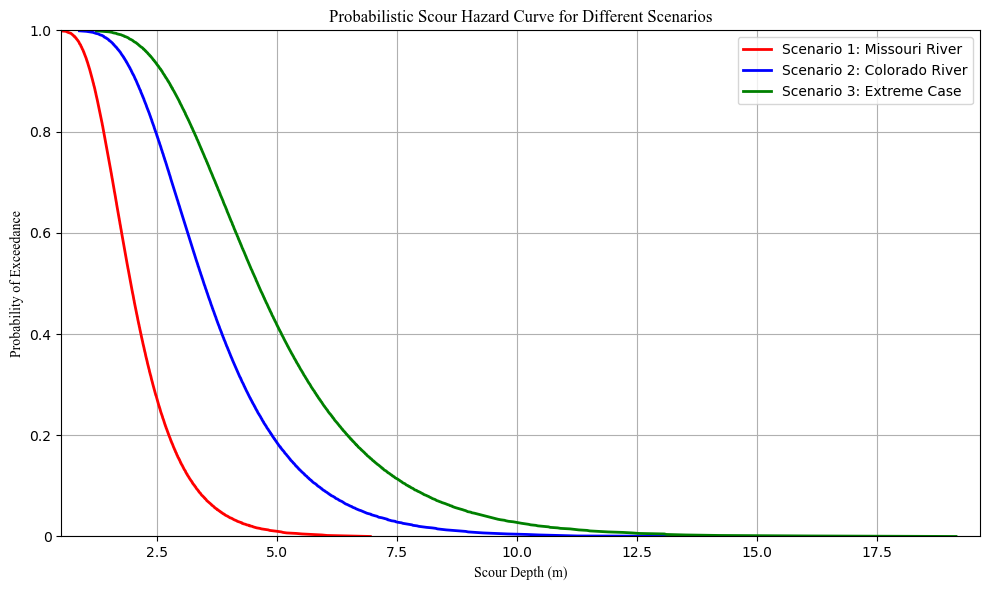

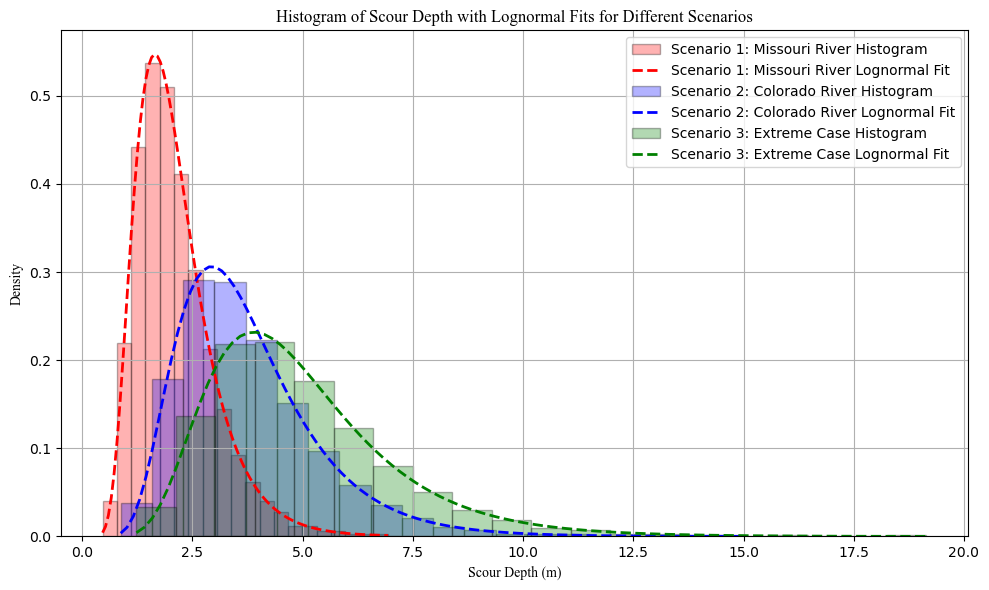

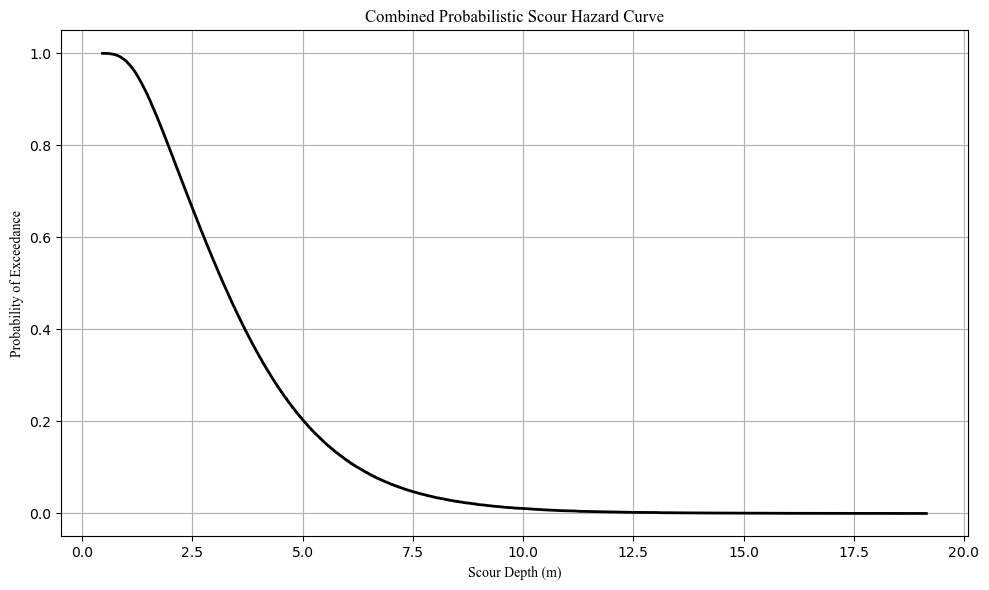

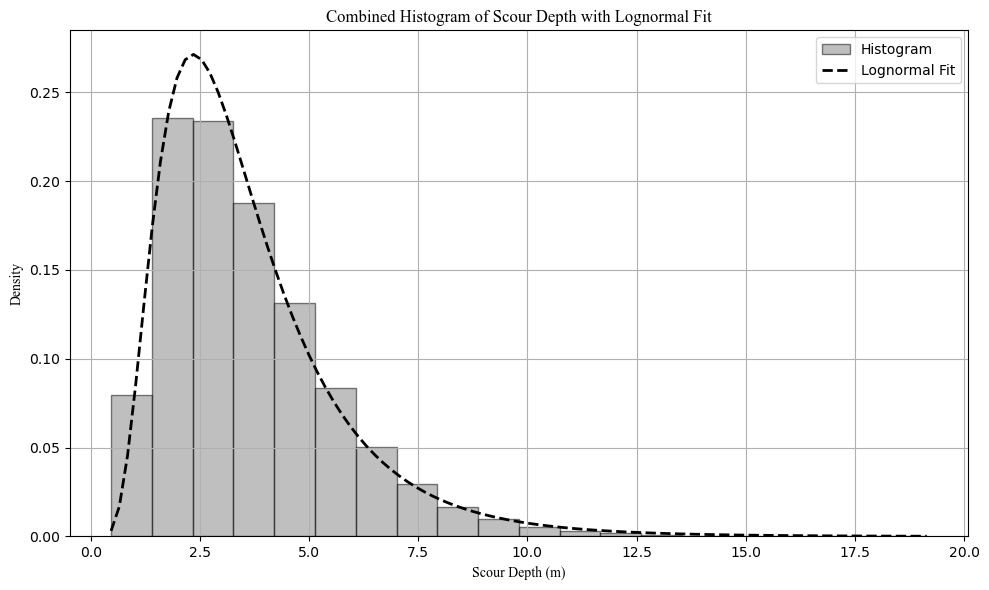

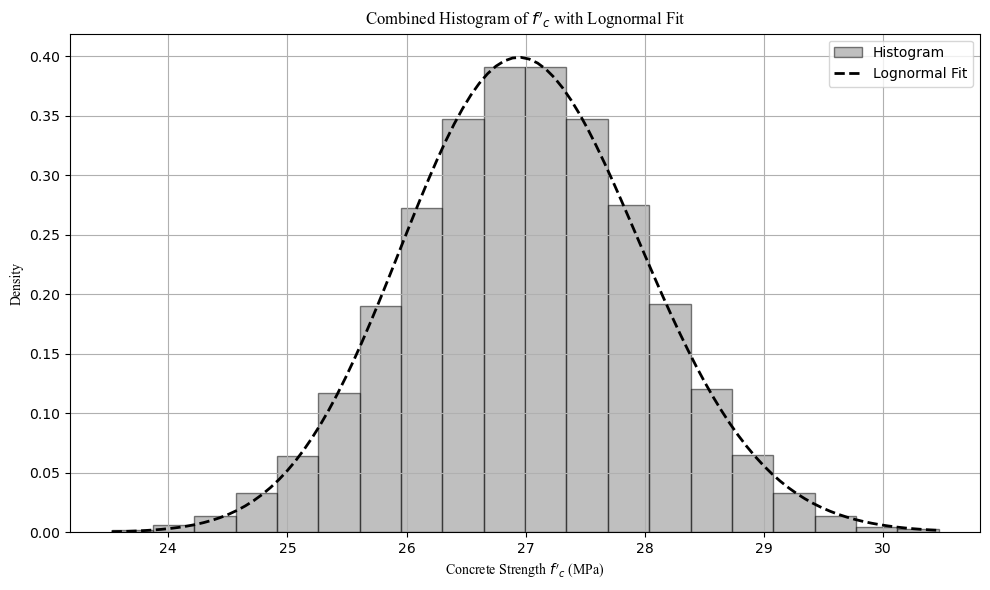

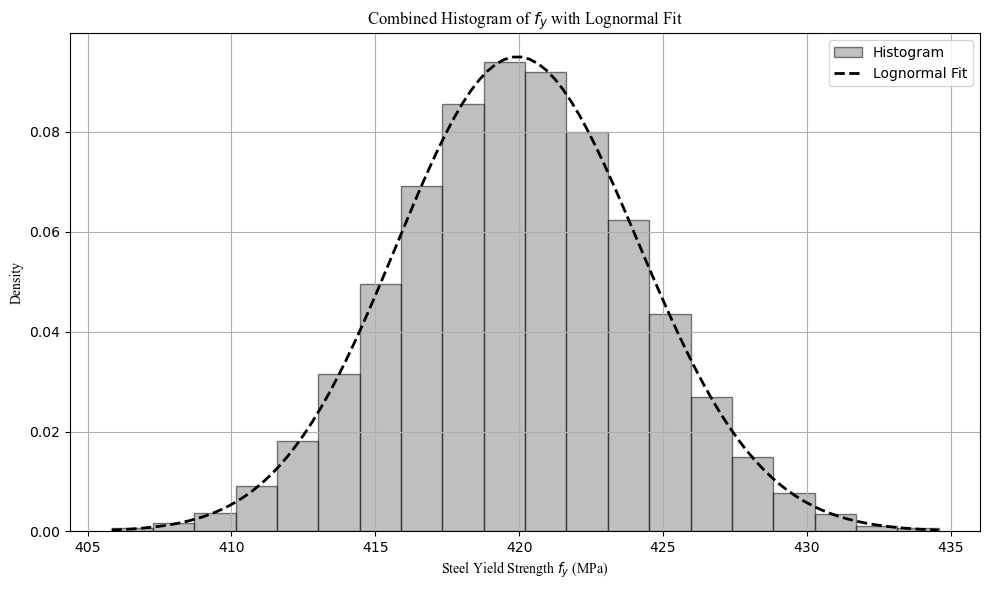

In [5]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# ── 1) Auto-find the latest export file ──
files = glob.glob("RecorderData/results/Scour_Materials_20250425.xlsx")
excel_path = max(files, key=os.path.getmtime)
print(f"Using Excel file: {os.path.basename(excel_path)}")

# Define save folder for plots
save_folder = os.path.dirname(excel_path)

# ── 2) Define your scenarios (labels and sheet names) ──
scenarios = [
    ("Scenario 1: Missouri River", "Scenario_1_Missouri_River"),
    ("Scenario 2: Colorado River", "Scenario_2_Colorado_River"),
    ("Scenario 3: Extreme Case",    "Scenario_3_Extreme_Case")
]
colors = ['red', 'blue', 'green']

# ── 3) Read data for each scenario ──
hazard_curves = []
histogram_data = []

for label, sheet in scenarios:
    df = pd.read_excel(excel_path, sheet_name=sheet)
    z_raw = df['Scour_Depth_mm'].values / 1000.0
    z_sorted = np.sort(z_raw)
    exceedance = 1.0 - np.arange(1, len(z_sorted)+1) / len(z_sorted)
    hazard_curves.append((label, z_sorted, exceedance))
    logMean = np.mean(np.log(z_raw))
    logStd = np.std(np.log(z_raw), ddof=1)
    histogram_data.append((label, z_raw, logMean, logStd))

# ── 4) Hazard Curve: All Scenarios ──
plt.figure(figsize=(10,6))
for i, (label, z_s, exc) in enumerate(hazard_curves):
    plt.plot(z_s, exc, color=colors[i], linewidth=2, label=label)
plt.xlim(0.5, max(z_s.max() for _, z_s, _ in hazard_curves) + 0.5)
plt.ylim(0, 0.98)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0], ['0','0.2','0.4','0.6','0.8','1.0'])
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Probability of Exceedance', fontsize=10, fontname='Times New Roman')
plt.title('Probabilistic Scour Hazard Curve for Different Scenarios', fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Figure01.pdf'))
plt.savefig(os.path.join(save_folder, 'HazardCurve_AllScenarios.png'), dpi=300)
plt.show()

# ── 5) Histogram + Lognormal Fit: All Scenarios ──
plt.figure(figsize=(10,6))
for i, (label, z_raw, logMean, logStd) in enumerate(histogram_data):
    plt.hist(z_raw, bins=20, density=True, alpha=0.3,
             edgecolor='black', color=colors[i], label=f'{label} Histogram')
    x = np.linspace(z_raw.min(), z_raw.max(), 100)
    pdf = lognorm.pdf(x, s=logStd, scale=np.exp(logMean))
    plt.plot(x, pdf, '--', linewidth=2, color=colors[i], label=f'{label} Lognormal Fit')
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Density', fontsize=10, fontname='Times New Roman')
plt.title('Histogram of Scour Depth with Lognormal Fits for Different Scenarios', fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Figure02.pdf'))
plt.savefig(os.path.join(save_folder, 'Histogram_ScourDepth_AllScenarios.png'), dpi=300)
plt.show()

# ── 6a) Combined Hazard Curve ──
all_z = np.hstack([z for _, z, _, _ in histogram_data])
z_sorted_all = np.sort(all_z)
exc_all = 1.0 - np.arange(1, len(z_sorted_all)+1) / len(z_sorted_all)

plt.figure(figsize=(10,6))
plt.plot(z_sorted_all, exc_all, '-k', linewidth=2)
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Probability of Exceedance', fontsize=10, fontname='Times New Roman')
plt.title('Combined Probabilistic Scour Hazard Curve', fontsize=12, fontname='Times New Roman')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Figure03.pdf'))
plt.savefig(os.path.join(save_folder, 'HazardCurve_Combined.png'), dpi=300)
plt.show()

# ── 6b) Combined Histogram + Lognormal Fit ──
logMean_all = np.mean(np.log(all_z))
logStd_all = np.std(np.log(all_z), ddof=1)

plt.figure(figsize=(10,6))
plt.hist(all_z, bins=20, density=True, alpha=0.5,
         color='gray', edgecolor='black', label='Histogram')
x = np.linspace(all_z.min(), all_z.max(), 100)
pdf_all = lognorm.pdf(x, s=logStd_all, scale=np.exp(logMean_all))
plt.plot(x, pdf_all, 'k--', linewidth=2, label='Lognormal Fit')
plt.xlabel('Scour Depth (m)', fontsize=10, fontname='Times New Roman')
plt.ylabel('Density', fontsize=10, fontname='Times New Roman')
plt.title('Combined Histogram of Scour Depth with Lognormal Fit', fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Figure04.pdf'))
plt.savefig(os.path.join(save_folder, 'Histogram_Combined_ScourDepth.png'), dpi=300)
plt.show()

# ── 7) Histogram of fc′ ──
fc_all = []
for _, sheet in scenarios:
    df = pd.read_excel(excel_path, sheet_name=sheet)
    fc_all.append(df["fc'_MPa"].values)
fc_all = np.hstack(fc_all)

logMean_fc = np.mean(np.log(fc_all))
logStd_fc = np.std(np.log(fc_all), ddof=1)

plt.figure(figsize=(10,6))
plt.hist(fc_all, bins=20, density=True, alpha=0.5,
         color='gray', edgecolor='black', label='Histogram')
x = np.linspace(fc_all.min(), fc_all.max(), 100)
pdf_fc = lognorm.pdf(x, s=logStd_fc, scale=np.exp(logMean_fc))
plt.plot(x, pdf_fc, 'k--', linewidth=2, label='Lognormal Fit')
plt.xlabel("Concrete Strength $f'_c$ (MPa)", fontsize=10, fontname='Times New Roman')
plt.ylabel('Density', fontsize=10, fontname='Times New Roman')
plt.title("Combined Histogram of $f'_c$ with Lognormal Fit", fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Figure05.pdf'))
plt.savefig(os.path.join(save_folder, 'Histogram_Combined_fc.png'), dpi=300)
plt.show()

# ── 8) Histogram of fy ──
fy_all = []
for _, sheet in scenarios:
    df = pd.read_excel(excel_path, sheet_name=sheet)
    fy_all.append(df["fy_MPa"].values)
fy_all = np.hstack(fy_all)

logMean_fy = np.mean(np.log(fy_all))
logStd_fy = np.std(np.log(fy_all), ddof=1)

plt.figure(figsize=(10,6))
plt.hist(fy_all, bins=20, density=True, alpha=0.5,
         color='gray', edgecolor='black', label='Histogram')
x = np.linspace(fy_all.min(), fy_all.max(), 100)
pdf_fy = lognorm.pdf(x, s=logStd_fy, scale=np.exp(logMean_fy))
plt.plot(x, pdf_fy, 'k--', linewidth=2, label='Lognormal Fit')
plt.xlabel("Steel Yield Strength $f_y$ (MPa)", fontsize=10, fontname='Times New Roman')
plt.ylabel('Density', fontsize=10, fontname='Times New Roman')
plt.title("Combined Histogram of $f_y$ with Lognormal Fit", fontsize=12, fontname='Times New Roman')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Figure06.pdf'))
plt.savefig(os.path.join(save_folder, 'Histogram_Combined_fy.png'), dpi=300)
plt.show()


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.stats import lognorm

# === CONFIGURATION ===
results_folder = Path("RecorderData")
output_folder = results_folder / "HazardPlots"
output_folder.mkdir(parents=True, exist_ok=True)

# Use the known capacity tuple file
lhs_file = results_folder / "Yield_Results_by_Scenario.xlsx"
if not lhs_file.exists():
    raise FileNotFoundError("❌ File 'Yield_Results_by_Scenario.xlsx' not found in RecorderData/.")

print(f"📊 Using: {lhs_file.name}")

# Load all sheets
sheet_data = pd.read_excel(lhs_file, sheet_name=None)

# Variables to process
variables = {
    "Scour_Depth_mm": "Scour Depth (m)",
    "Vy_kN": "Base Shear $V_y$ (kN)",
    "dy_mm": "Top Displacement $\\Delta_y$ (mm)",
    "My_kNm": "Moment $M_y$ (kN·m)",
    "Thy_rad": "Rotation $\\Theta_y$ (rad)"
}

colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

# === PROCESSING LOOP ===
for var_key, var_label in variables.items():
    hazard_curves = []
    histogram_data = []
    all_values = []

    for i, (sheet_name, df) in enumerate(sheet_data.items()):
        if var_key not in df.columns:
            print(f"⚠️ {var_key} not found in {sheet_name}. Skipping.")
            continue

        values = df[var_key].values
        if var_key == "Scour_Depth_mm":
            values = values / 1000  # mm → m

        values = values[values > 0]
        if len(values) == 0:
            print(f"⚠️ No positive values for {var_key} in {sheet_name}. Skipping.")
            continue

        sorted_vals = np.sort(values)
        log_vals = np.log(values)
        logMean = np.mean(log_vals)
        logStd = np.std(log_vals)
        exceedance = 1 - lognorm.cdf(sorted_vals, s=logStd, scale=np.exp(logMean))

        hazard_curves.append((sheet_name, sorted_vals, exceedance))
        histogram_data.append((sheet_name, values, logMean, logStd))
        all_values.extend(values)

    if not hazard_curves:
        print(f"🚫 Skipping {var_key} — no valid data.")
        continue

    # Clean variable name for filenames
    clean_var = (
        var_key.replace(' ', '_')
        .replace('(', '')
        .replace(')', '')
        .replace('·', '')
        .replace('$', '')
        .replace('\\', '')
    )

    # === Plot 1: Exceedance Curve (LINEAR scale) ===
    plt.figure(figsize=(10, 6))
    for i, (name, sorted_vals, exceedance) in enumerate(hazard_curves):
        plt.plot(sorted_vals, exceedance, color=colors[i % len(colors)], linewidth=2, label=name)

    plt.xscale("linear")  # ⬅️ UPDATED to linear scale
    plt.ylim([0, 1.0])
    plt.xlabel(var_label, fontsize=11, fontname='Times New Roman')
    plt.ylabel("Probability of Exceedance", fontsize=11, fontname='Times New Roman')
    plt.title(f"Exceedance Curve for {var_label}", fontsize=13, fontname='Times New Roman')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()

    hazard_path = output_folder / f"hazard_{clean_var}.png"
    plt.savefig(hazard_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved hazard curve: {hazard_path.name}")

    # === Plot 2: Histogram + Lognormal Fit ===
    plt.figure(figsize=(10, 6))
    for i, (name, raw_vals, logMean, logStd) in enumerate(histogram_data):
        plt.hist(raw_vals, bins=20, density=True, alpha=0.3, edgecolor='black',
                 color=colors[i % len(colors)], label=f'{name} Histogram')

        x_vals = np.linspace(np.min(raw_vals), np.max(raw_vals), 100)
        pdf = lognorm.pdf(x_vals, s=logStd, scale=np.exp(logMean))
        plt.plot(x_vals, pdf, '--', linewidth=2, color=colors[i % len(colors)],
                 label=f'{name} Lognormal Fit')

    plt.xlabel(var_label, fontsize=11, fontname='Times New Roman')
    plt.ylabel("Density", fontsize=11, fontname='Times New Roman')
    plt.title(f"Histogram + Lognormal Fit for {var_label}", fontsize=13, fontname='Times New Roman')
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()

    hist_path = output_folder / f"hist_{clean_var}.png"
    plt.savefig(hist_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved histogram: {hist_path.name}")


📊 Using: Yield_Results_by_Scenario.xlsx
✅ Saved hazard curve: hazard_Scour_Depth_mm.png
✅ Saved histogram: hist_Scour_Depth_mm.png
✅ Saved hazard curve: hazard_Vy_kN.png
✅ Saved histogram: hist_Vy_kN.png
✅ Saved hazard curve: hazard_dy_mm.png
✅ Saved histogram: hist_dy_mm.png
✅ Saved hazard curve: hazard_My_kNm.png
✅ Saved histogram: hist_My_kNm.png
✅ Saved hazard curve: hazard_Thy_rad.png
✅ Saved histogram: hist_Thy_rad.png


📊 Using capacity tuple file: Yield_Results_by_Scenario.xlsx


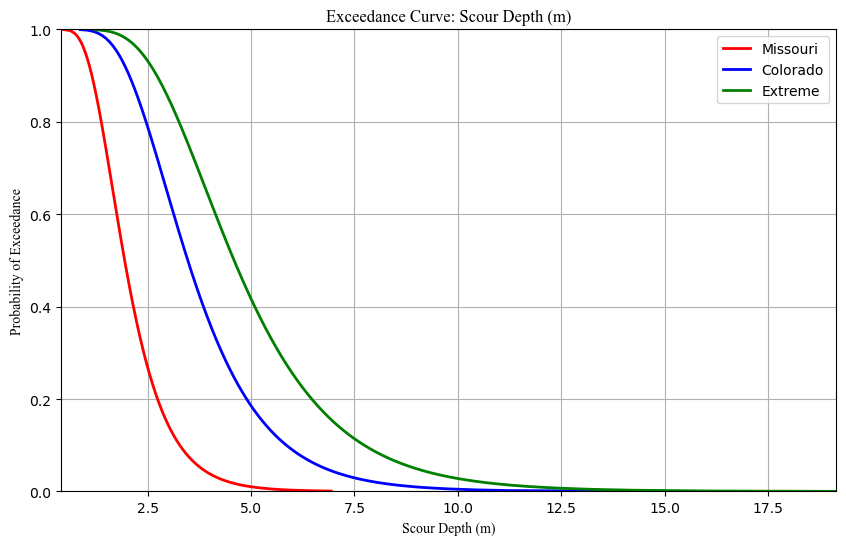

✅ Saved hazard curve: hazard_curve_Scour_Depth_mm.png


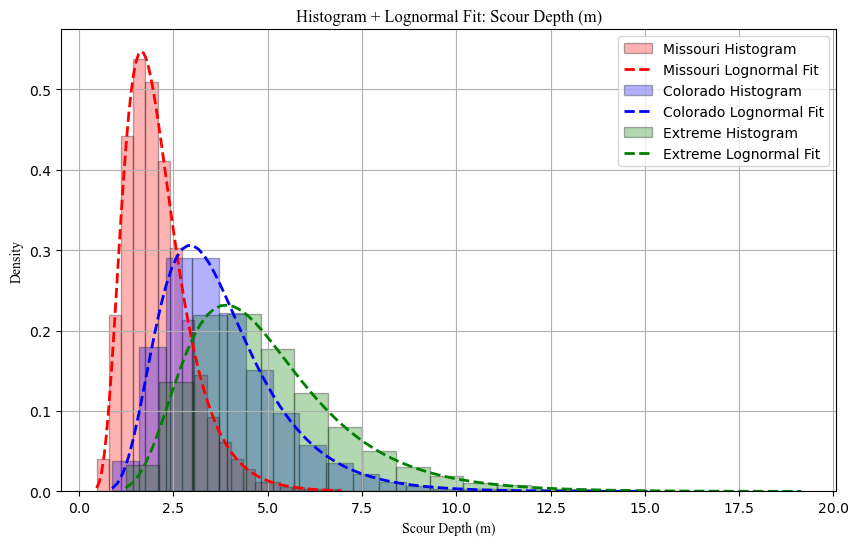

✅ Saved histogram plot: hist_lognormal_Scour_Depth_mm.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import lognorm
import os

# --- CONFIGURATION ---
base_folder = Path("RecorderData")
results_folder = base_folder / "HazardPlots"
results_folder.mkdir(parents=True, exist_ok=True)

# Locate latest capacity tuple file
capacity_file = base_folder / "Yield_Results_by_Scenario.xlsx"
if not capacity_file.exists():
    raise FileNotFoundError("❌ 'Yield_Results_by_Scenario.xlsx' not found in RecorderData/")

print(f"📊 Using capacity tuple file: {capacity_file.name}")

# Load all sheets
sheet_data = pd.read_excel(capacity_file, sheet_name=None)

# Variable to process
variables = {
    "Scour_Depth_mm": "Scour Depth (m)"
}

colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

# Process each variable
for var_key, var_label in variables.items():
    hazard_curves = []
    histogram_data = []
    all_values = []

    for i, (sheet_name, df) in enumerate(sheet_data.items()):
        if var_key not in df.columns:
            print(f"⚠️ Column '{var_key}' not found in {sheet_name}. Skipping.")
            continue

        values = df[var_key].values / 1000 if var_key == "Scour_Depth_mm" else df[var_key].values
        values = values[values > 0]

        if len(values) == 0:
            print(f"⚠️ No valid values for {var_key} in {sheet_name}. Skipping.")
            continue

        sorted_vals = np.sort(values)
        log_vals = np.log(values)
        logMean = np.mean(log_vals)
        logStd = np.std(log_vals)
        exceedance = 1 - lognorm.cdf(sorted_vals, s=logStd, scale=np.exp(logMean))

        hazard_curves.append((sheet_name, sorted_vals, exceedance))
        histogram_data.append((sheet_name, values, logMean, logStd))
        all_values.extend(values)

    if not hazard_curves:
        print(f"🚫 Skipping {var_key} — no data.")
        continue

    # === Exceedance Plot ===
    plt.figure(figsize=(10, 6))
    for i, (name, sorted_vals, exceedance) in enumerate(hazard_curves):
        plt.plot(sorted_vals, exceedance, label=name, linewidth=2, color=colors[i % len(colors)])

    x_min = max(0.9 * np.min(all_values), 1e-6)
    x_max = np.max(all_values)
    plt.xlim([x_min, x_max])
    plt.ylim([0, 1])
    plt.xlabel(var_label, fontsize=10, fontname='Times New Roman')
    plt.ylabel("Probability of Exceedance", fontsize=10, fontname='Times New Roman')
    plt.title(f"Exceedance Curve: {var_label}", fontsize=12, fontname='Times New Roman')
    plt.grid(True)
    plt.legend()
    out_path = results_folder / f"hazard_curve_{var_key.replace(' ', '_')}.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved hazard curve: {out_path.name}")

    # === Histogram + Lognormal Fit ===
    plt.figure(figsize=(10, 6))
    for i, (name, values, logMean, logStd) in enumerate(histogram_data):
        plt.hist(values, bins=20, density=True, alpha=0.3, edgecolor='black',
                 color=colors[i % len(colors)], label=f'{name} Histogram')
        x_vals = np.linspace(np.min(values), np.max(values), 100)
        pdf = lognorm.pdf(x_vals, s=logStd, scale=np.exp(logMean))
        plt.plot(x_vals, pdf, '--', linewidth=2, color=colors[i % len(colors)],
                 label=f'{name} Lognormal Fit')

    plt.xlabel(var_label, fontsize=10, fontname='Times New Roman')
    plt.ylabel("Density", fontsize=10, fontname='Times New Roman')
    plt.title(f"Histogram + Lognormal Fit: {var_label}", fontsize=12, fontname='Times New Roman')
    plt.grid(True)
    plt.legend()
    out_path = results_folder / f"hist_lognormal_{var_key.replace(' ', '_')}.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved histogram plot: {out_path.name}")


📊 Using capacity tuples: Yield_Results_by_Scenario.xlsx


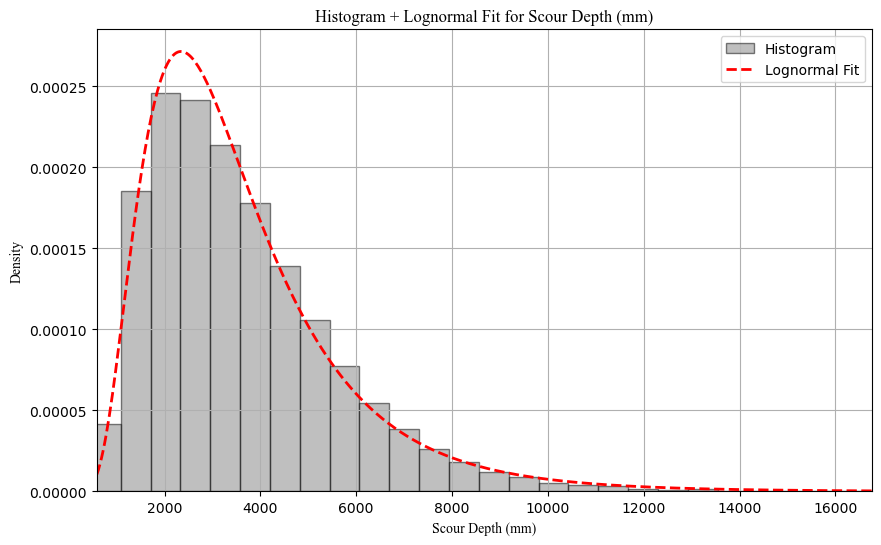

✅ Saved: RecorderData\HazardPlots\Figure07.pdf


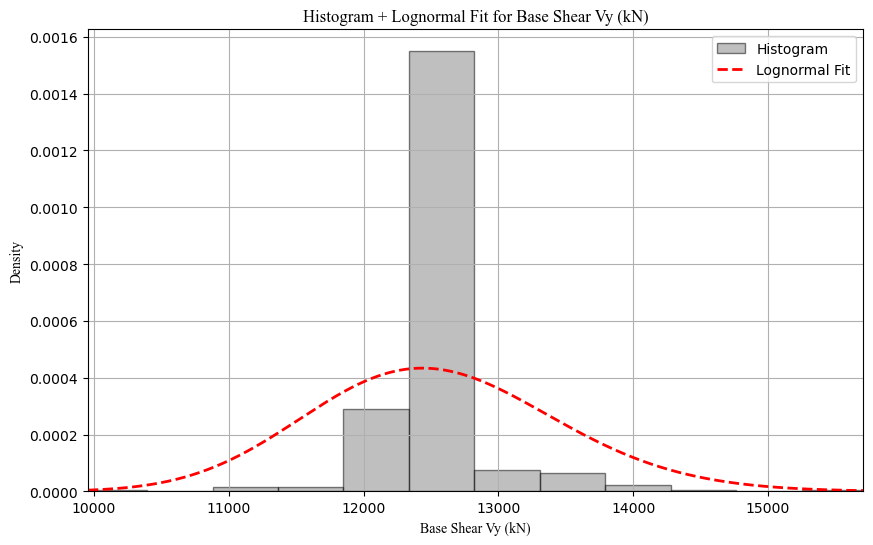

✅ Saved: RecorderData\HazardPlots\Figure08.pdf


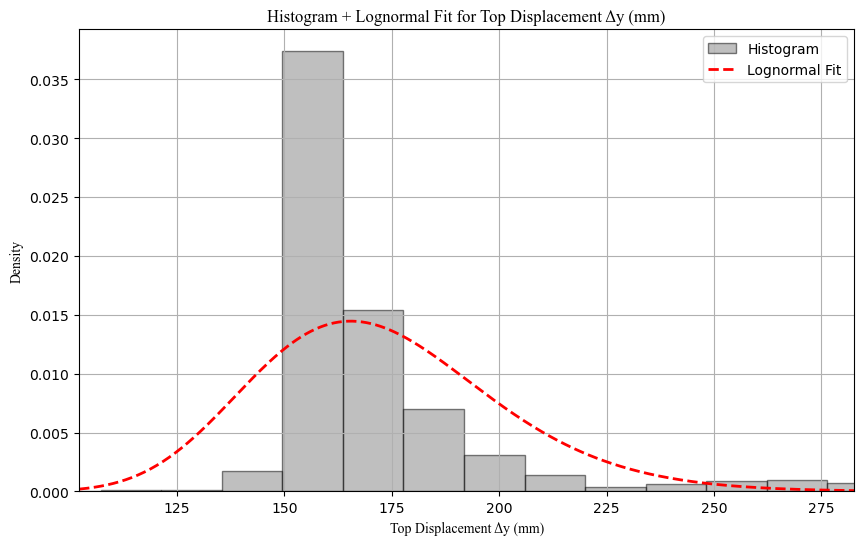

✅ Saved: RecorderData\HazardPlots\Figure09.pdf


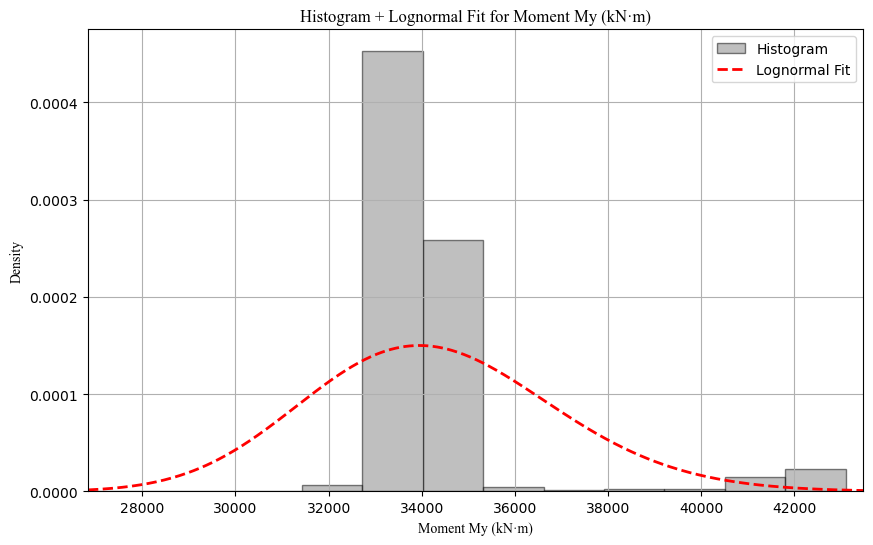

✅ Saved: RecorderData\HazardPlots\Figure10.pdf


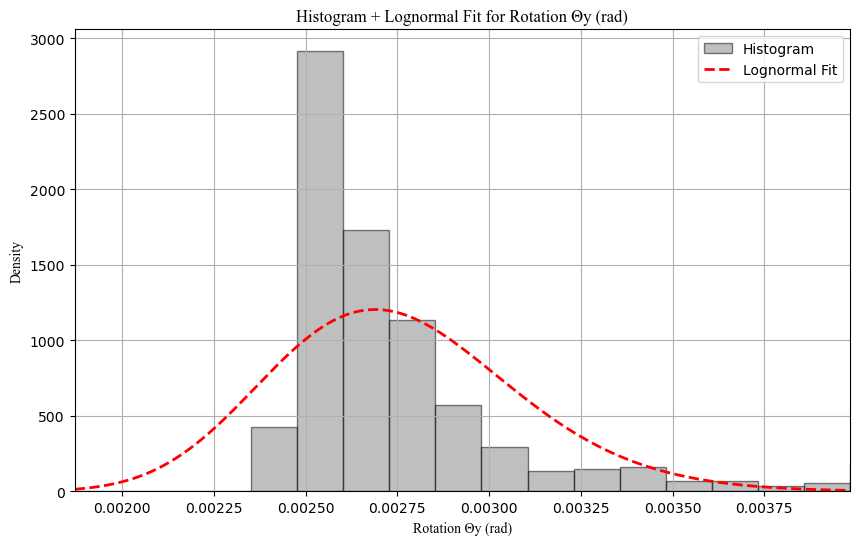

✅ Saved: RecorderData\HazardPlots\Figure11.pdf


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.stats import lognorm

# --- CONFIGURATION ---
results_folder = Path("RecorderData")
output_path_dir = results_folder / "HazardPlots"
output_path_dir.mkdir(parents=True, exist_ok=True)

# Use the known capacity tuple file
xls_file = results_folder / "Yield_Results_by_Scenario.xlsx"
if not xls_file.exists():
    raise FileNotFoundError("❌ File 'Yield_Results_by_Scenario.xlsx' not found in RecorderData/.")

print(f"📊 Using capacity tuples: {xls_file.name}")

# Load and stack all sheets
sheet_data = pd.read_excel(xls_file, sheet_name=None)
df_all = pd.concat(sheet_data.values(), ignore_index=True)

# Filter only positive values
df_all = df_all[
    (df_all["Scour_Depth_mm"] > 0) &
    (df_all["Vy_kN"] > 0) &
    (df_all["dy_mm"] > 0) &
    (df_all["My_kNm"] > 0) &
    (df_all["Thy_rad"] > 0)
]

# Define variables and figure names
var_list = [
    ("Scour_Depth_mm", "Scour Depth (mm)", "Figure07.pdf"),
    ("Vy_kN", "Base Shear Vy (kN)", "Figure08.pdf"),
    ("dy_mm", "Top Displacement Δy (mm)", "Figure09.pdf"),
    ("My_kNm", "Moment My (kN·m)", "Figure10.pdf"),
    ("Thy_rad", "Rotation Θy (rad)", "Figure11.pdf")
]

# Process and plot
for var, label, fig_name in var_list:
    data = df_all[var].values
    log_vals = np.log(data)
    logMean = np.mean(log_vals)
    logStd = np.std(log_vals)

    # Expanded range for full PDF
    x_vals = np.linspace(
        lognorm.ppf(0.001, s=logStd, scale=np.exp(logMean)),
        lognorm.ppf(0.999, s=logStd, scale=np.exp(logMean)),
        500
    )
    pdf_vals = lognorm.pdf(x_vals, s=logStd, scale=np.exp(logMean))

    # Plot
    plt.figure(figsize=(10, 6))
    counts, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', edgecolor='black', label="Histogram")
    plt.plot(x_vals, pdf_vals, 'r--', linewidth=2, label="Lognormal Fit")

    plt.xlabel(label, fontsize=10, fontname='Times New Roman')
    plt.ylabel("Density", fontsize=10, fontname='Times New Roman')
    plt.title(f"Histogram + Lognormal Fit for {label}", fontsize=12, fontname='Times New Roman')
    plt.grid(True)
    plt.legend()

    # Autoscale limits
    plt.xlim(x_vals[0], x_vals[-1])
    y_max = max(np.max(pdf_vals), np.max(counts)) * 1.05
    plt.ylim(0, y_max)

    # Save PDF and PNG
    pdf_path = output_path_dir / fig_name
    png_path = output_path_dir / f"hist_lognormal_{var}.png"
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {pdf_path}")


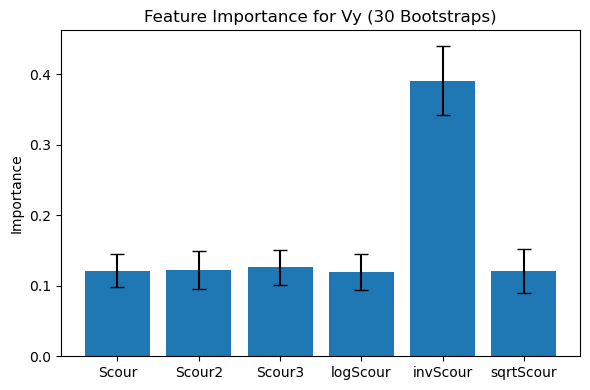

Predictions for Scour=500 mm across 30 models:
  min = 12281.91 kN
  median = 12663.88 kN
  max = 12687.85 kN


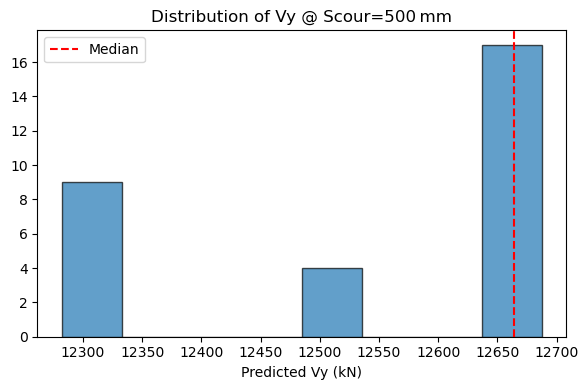

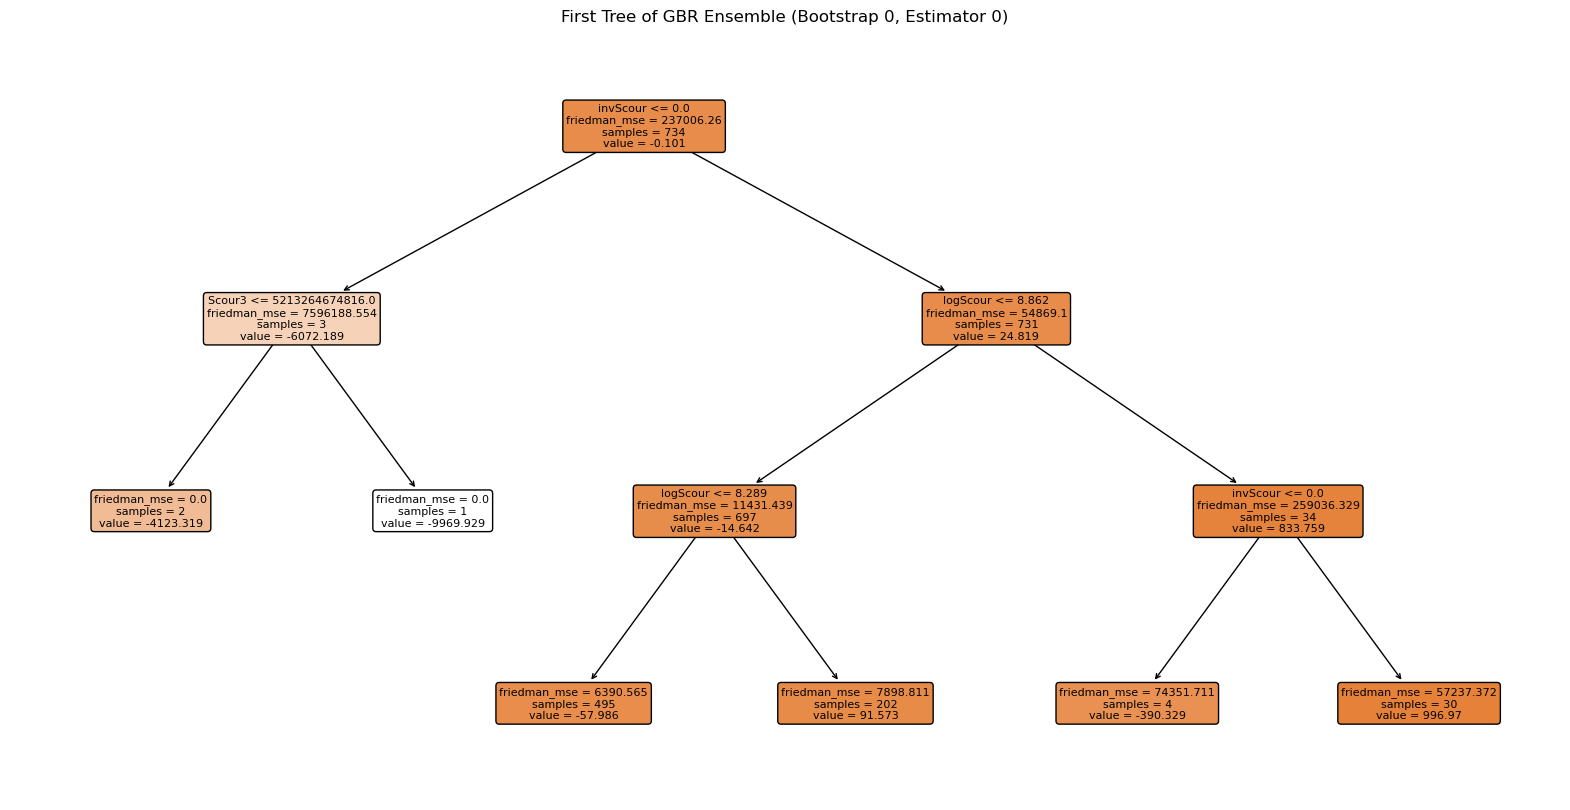

In [11]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import tree

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal")
target = "Vy"
n_boot = 30
features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]

# --- Load all 30 models ---
models = [
    joblib.load(model_folder / f"credal_model_{target}_boot{i}.pkl")
    for i in range(n_boot)
]

# --- 1) Combined Feature Importance (mean ± std) ---
importances = np.vstack([m.feature_importances_ for m in models])  # shape (30,6)
mean_imp = importances.mean(axis=0)
std_imp  = importances.std(axis=0)

plt.figure(figsize=(6,4))
plt.bar(features, mean_imp, yerr=std_imp, capsize=5)
plt.ylabel("Importance")
plt.title(f"Feature Importance for {target} (30 Bootstraps)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2) Sample Prediction Distribution @ Scour=500 mm ---
sz = 500
sample = np.array([[sz, sz**2, sz**3, np.log(sz), 1/sz, np.sqrt(sz)]])

# gather all predictions
preds = np.array([m.predict(sample)[0] for m in models])
print(f"Predictions for Scour={sz} mm across 30 models:")
print(f"  min = {preds.min():.2f} kN")
print(f"  median = {np.median(preds):.2f} kN")
print(f"  max = {preds.max():.2f} kN")

# optional: histogram of the 30 predictions
plt.figure(figsize=(6,4))
plt.hist(preds, bins=8, edgecolor="k", alpha=0.7)
plt.axvline(np.median(preds), color='r', linestyle='--', label="Median")
plt.xlabel(f"Predicted {target} (kN)")
plt.title(f"Distribution of {target} @ Scour={sz} mm")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3) Visualize the first tree of the first bootstrap ---
plt.figure(figsize=(20,10))
tree.plot_tree(
    models[0].estimators_[0,0],
    filled=True,
    feature_names=features,
    rounded=True,
    fontsize=8
)
plt.title("First Tree of GBR Ensemble (Bootstrap 0, Estimator 0)")
plt.show()


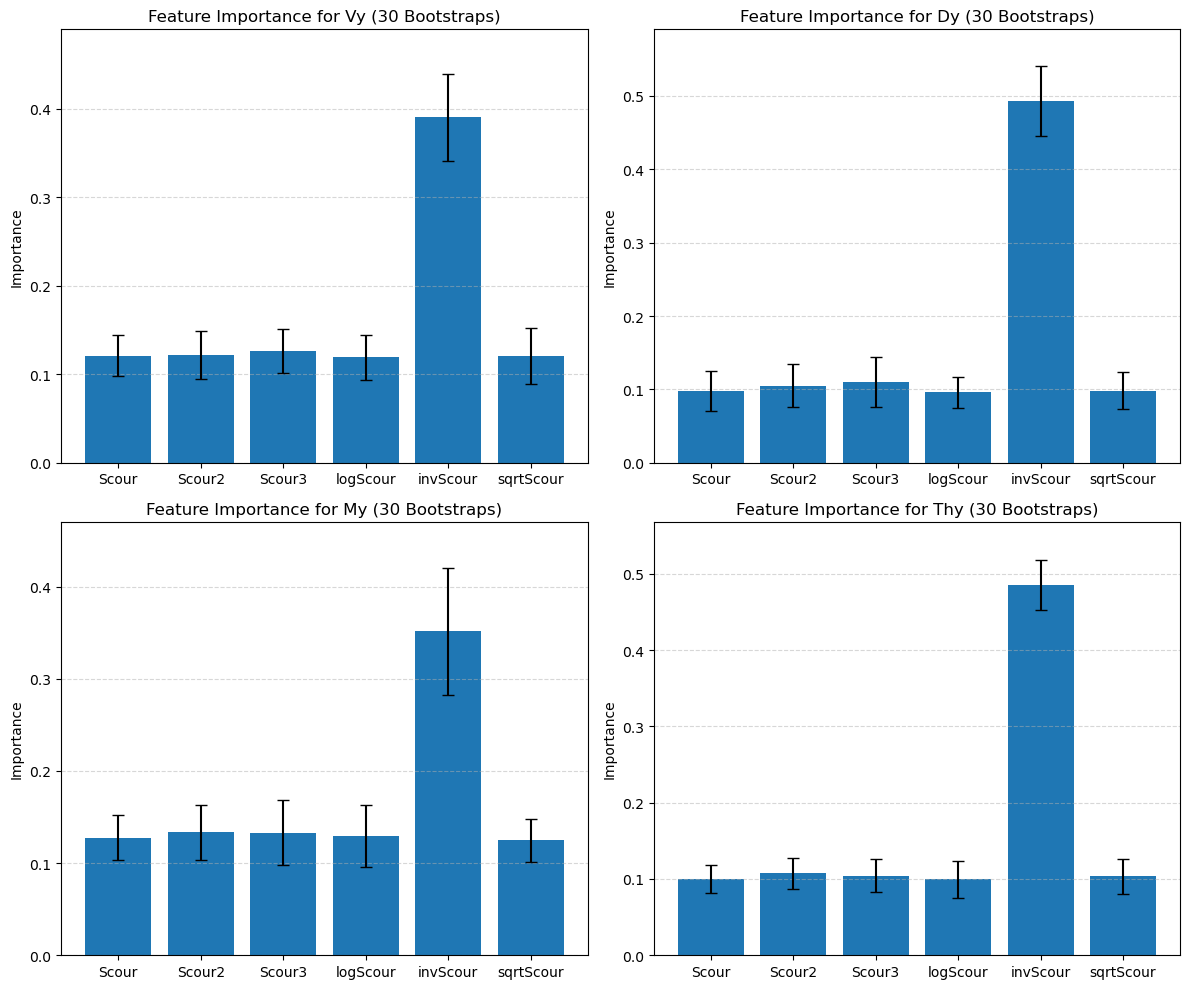

In [13]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal")
targets      = ['Vy','Dy','My','Thy']
features     = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]
n_boot       = 30

# --- Prepare subplots ---
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()

for ax, target in zip(axes, targets):
    # load all 30 bootstrapped GBRs for this target
    importances = np.vstack([
        joblib.load(model_folder / f"credal_model_{target}_boot{i}.pkl").feature_importances_
        for i in range(n_boot)
    ])  # shape = (30, 6)
    
    mean_imp = importances.mean(axis=0)
    std_imp  = importances.std(axis=0)
    
    # bar plot
    ax.bar(features, mean_imp, yerr=std_imp, capsize=4)
    ax.set_title(f"Feature Importance for {target} (30 Bootstraps)")
    ax.set_ylabel("Importance")
    ax.set_ylim(0, mean_imp.max() + std_imp.max() + 0.05)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


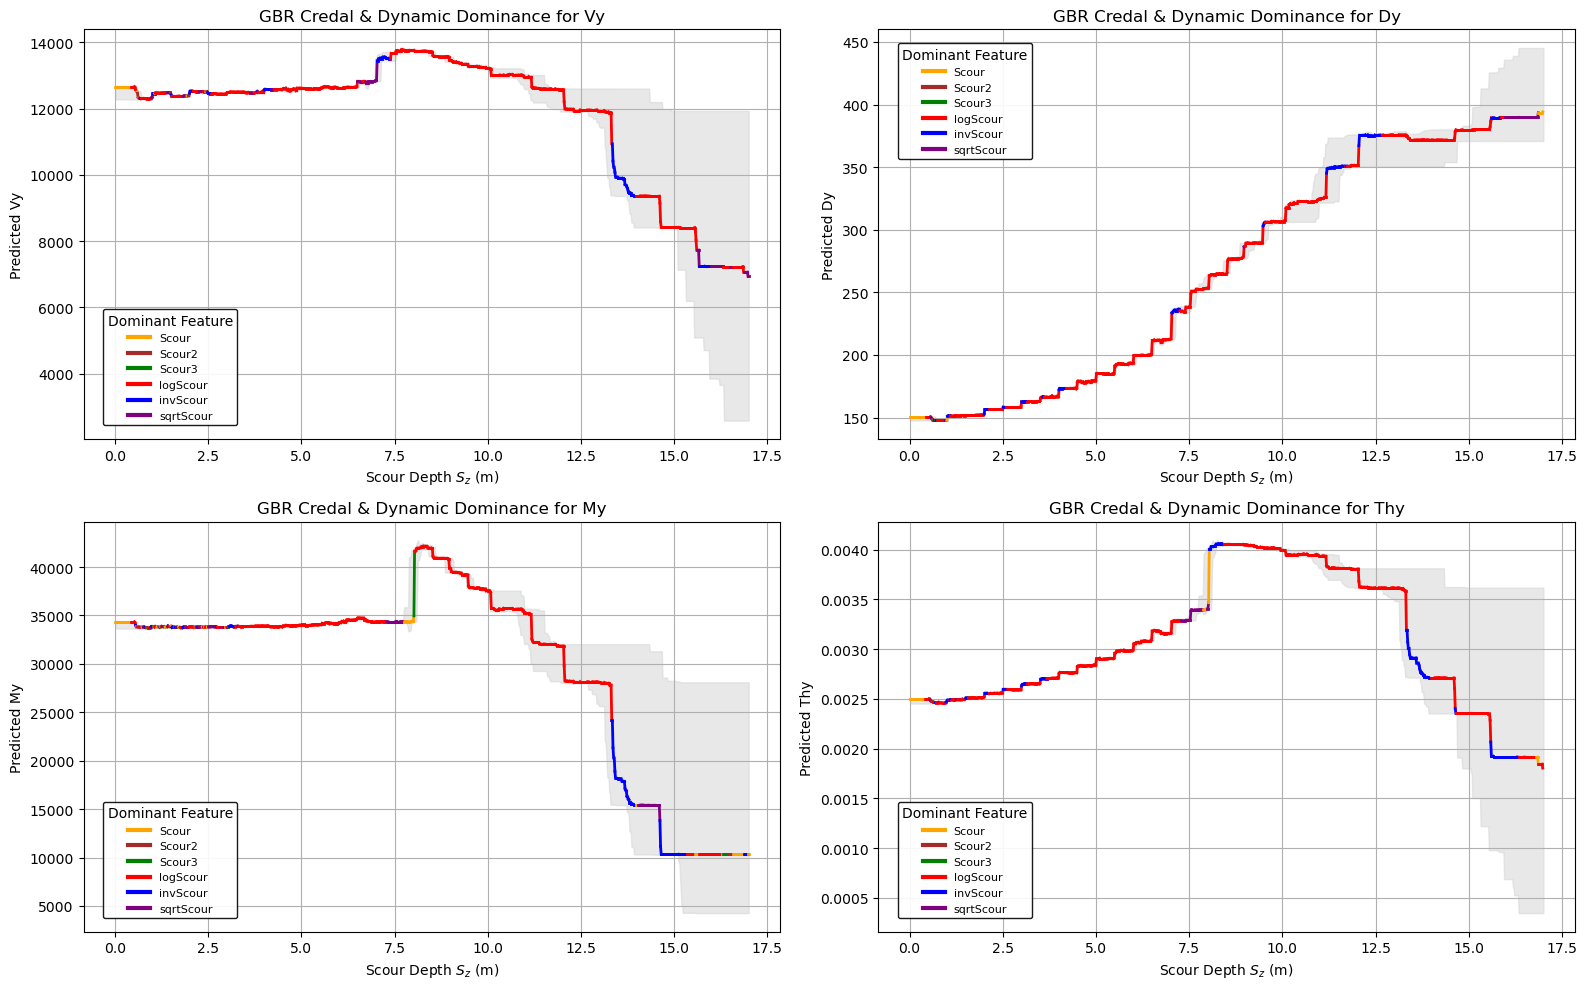

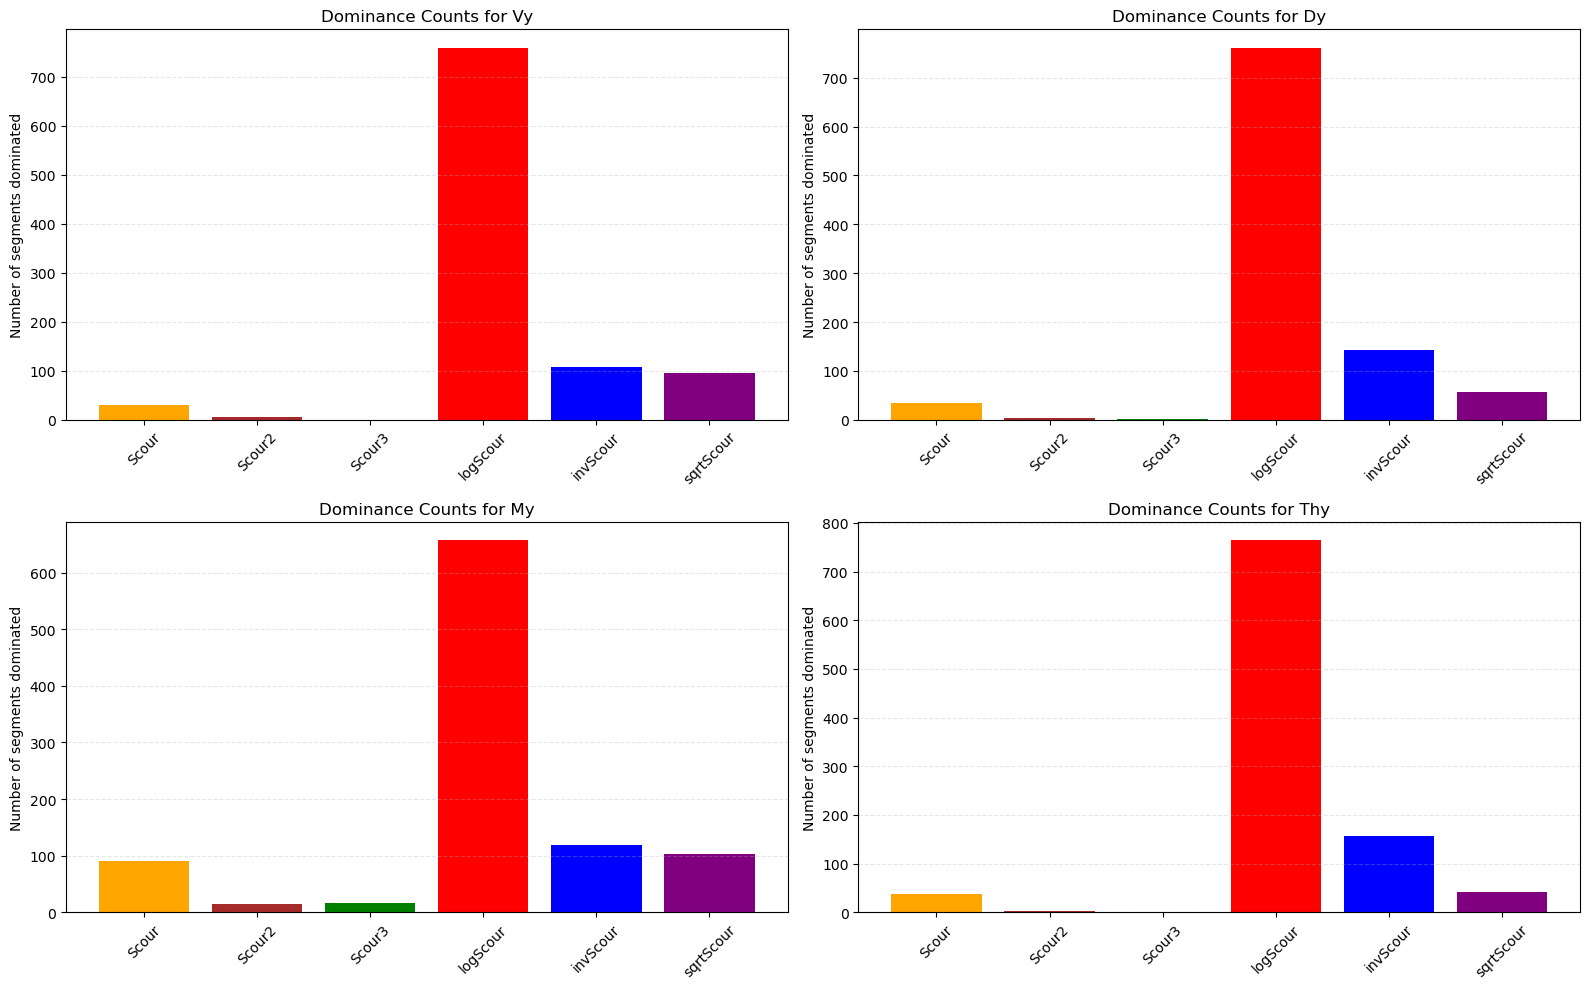

In [19]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from collections import Counter

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal")
targets      = ['Vy','Dy','My','Thy']
features     = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]
feature_colors = {
    "Scour":    'orange',
    "Scour2":   'brown',
    "Scour3":   'green',
    "logScour": 'red',
    "invScour": 'blue',
    "sqrtScour":'purple'
}
perturb = 1.05  # +5%

# --- Build scour vector & engineered inputs ---
sz_m = np.linspace(0.01,17,1000)
X_raw = np.column_stack([
    sz_m*1000,
    (sz_m*1000)**2,
    (sz_m*1000)**3,
    np.log(sz_m*1000),
    1/(sz_m*1000),
    np.sqrt(sz_m*1000)
])

# --- 1) Plot dynamic-dominance curves and collect dom lists ---
dom_dict = {}
fig1, axes1 = plt.subplots(2,2,figsize=(16,10))
axes1 = axes1.ravel()

for ax, target in zip(axes1, targets):
    # load bootstraps
    models = [joblib.load(model_folder/f"credal_model_{target}_boot{i}.pkl")
              for i in range(30)]

    # credal band
    all_preds = np.stack([m.predict(X_raw) for m in models], axis=0)
    pred_lo, pred_hi = all_preds.min(axis=0), all_preds.max(axis=0)
    pred_med        = np.median(all_preds, axis=0)

    # dynamic dominance
    dom = []
    for i in range(len(sz_m)):
        base    = X_raw[i:i+1,:]
        med_val = np.median([m.predict(base)[0] for m in models])
        deltas  = []
        for j in range(len(features)):
            p = base.copy()
            p[0,j] *= perturb
            pert = np.median([m.predict(p)[0] for m in models])
            deltas.append(abs(pert - med_val))
        dom.append(features[np.argmax(deltas)])
    dom_dict[target] = dom

    # plot
    ax.fill_between(sz_m, pred_lo, pred_hi, color='lightgray', alpha=0.5, zorder=1)
    for i in range(len(sz_m)-1):
        ax.plot(sz_m[i:i+2], pred_med[i:i+2],
                color=feature_colors[dom[i]], lw=2, zorder=2)

    ax.set_title(f"GBR Credal & Dynamic Dominance for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(f"Predicted {target}")
    ax.grid(True)

    # legend
    legend_elems = [Line2D([0],[0], color=feature_colors[f], lw=3, label=f)
                    for f in features]
    loc = 'upper left' if target=='Dy' else 'lower left'
    bbox = (0.02,0.98) if target=='Dy' else (0.02,0.02)
    ax.legend(handles=legend_elems, title="Dominant Feature",
              loc=loc, bbox_to_anchor=bbox,
              frameon=True, fancybox=True, edgecolor="black",
              fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.show()


# --- 2) Plot bar-charts of dominance counts for each target ---
fig2, axes2 = plt.subplots(2,2,figsize=(16,10))
axes2 = axes2.ravel()

for ax, target in zip(axes2, targets):
    counts = Counter(dom_dict[target])
    values = [counts[f] for f in features]

    ax.bar(range(len(features)), values,
           color=[feature_colors[f] for f in features])
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45)
    ax.set_title(f"Dominance Counts for {target}")
    ax.set_ylabel("Number of segments dominated")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


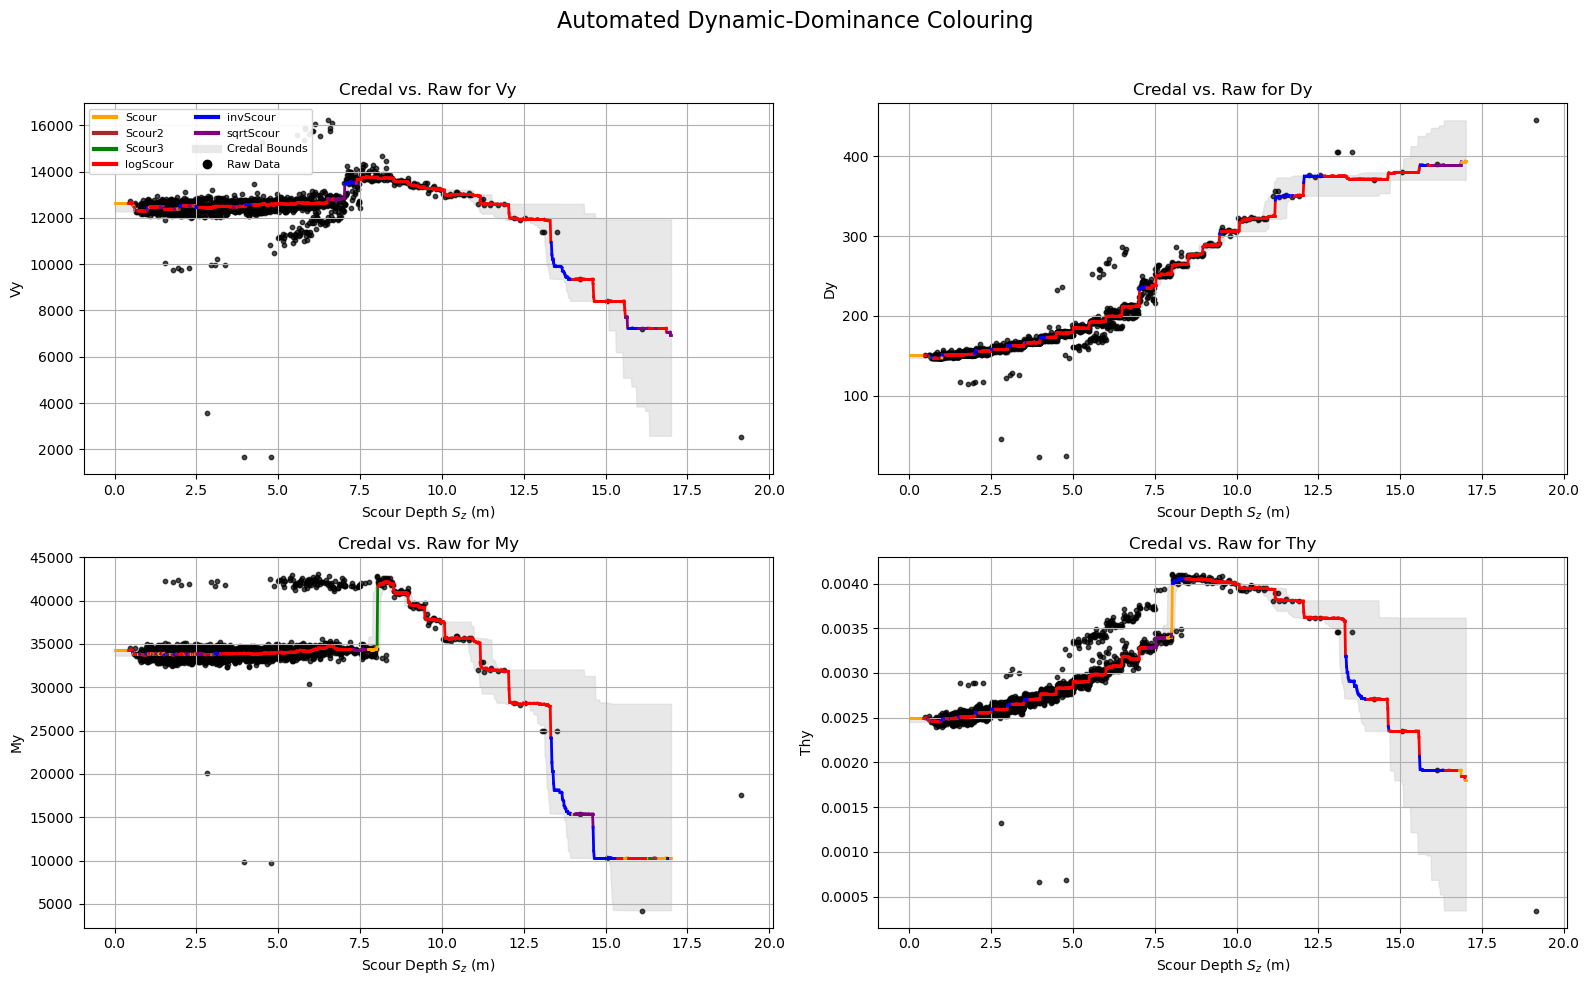

In [21]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- Setup ---
model_folder   = Path(r"RecorderData\results\Tuple_Data_Process\ML_Surrogate_Credal")
raw_data_path  = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
targets        = ['Vy', 'Dy', 'My', 'Thy']
raw_columns    = ['Vy_kN', 'dy_mm', 'My_kNm', 'Thy_rad']

# define your colour map for each feature
feature_names  = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
feature_colors = {
    "Scour":    'orange',
    "Scour2":   'brown',
    "Scour3":   'green',
    "logScour": 'red',
    "invScour": 'blue',
    "sqrtScour":'purple'
}

perturb = 1.05  # +5% for the dynamic-dominance test

# --- Build scour vector & features matrix ---
sz_m      = np.linspace(0.01,17,1000)
X_raw     = np.column_stack([
    sz_m*1000,               # Scour in mm
    (sz_m*1000)**2,          # Scour^2
    (sz_m*1000)**3,          # Scour^3
    np.log(sz_m*1000),       # log(Scour)
    1/(sz_m*1000),           # invScour
    np.sqrt(sz_m*1000)       # sqrtScour
])

# --- Load raw scatter data once ---
df_raw = pd.concat(pd.read_excel(raw_data_path, sheet_name=None),
                   ignore_index=True)

# --- Prepare figure ---
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs = axs.flatten()

for ax, target, raw_col in zip(axs, targets, raw_columns):
    # 1) Load all 30 bootstrapped models and predict across the grid
    models    = [ joblib.load(model_folder/f"credal_model_{target}_boot{i}.pkl")
                  for i in range(30) ]
    all_preds = np.stack([m.predict(X_raw) for m in models], axis=0)
    y_lo      = all_preds.min(axis=0)
    y_hi      = all_preds.max(axis=0)
    y_med     = np.median(all_preds, axis=0)

    # 2) Compute dynamic dominance at each point
    dom = []
    for i in range(len(sz_m)):
        base     = X_raw[i:i+1,:]
        med_val  = np.median([m.predict(base)[0] for m in models])
        deltas   = []
        for j, feat in enumerate(feature_names):
            p       = base.copy()
            p[0,j] *= perturb
            pert    = np.median([m.predict(p)[0] for m in models])
            deltas.append(abs(pert - med_val))
        dom.append(feature_names[np.argmax(deltas)])

    # 3) Plot credal band
    ax.fill_between(sz_m, y_lo, y_hi,
                    color='lightgray', alpha=0.5,
                    label="Credal Bounds")

    # 4) Plot median curve in tiny coloured segments
    for i in range(len(sz_m)-1):
        c = feature_colors[dom[i]]
        ax.plot(sz_m[i:i+2], y_med[i:i+2],
                color=c, lw=2)

    # 5) Overlay raw data
    ax.scatter(df_raw["Scour_Depth_mm"]/1000,
               df_raw[raw_col],
               color='black', s=10, alpha=0.7,
               label="Raw Data")

    # 6) Decorations
    ax.set_title(f"Credal vs. Raw for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(f"{target}")
    ax.grid(True)

# one legend for the top-left only
legend_handles = [ plt.Line2D([0],[0], color=feature_colors[f], lw=3, label=f)
                   for f in feature_names ]
legend_handles += [ plt.Line2D([0],[0], color='lightgray', lw=6, alpha=0.5,
                   label="Credal Bounds"),
                    plt.Line2D([0],[0], marker='o', color='black', 
                   label="Raw Data", linestyle='') ]

axs[0].legend(handles=legend_handles, ncol=2, fontsize=8,
              framealpha=0.9, loc='upper left')

plt.suptitle("Automated Dynamic‐Dominance Colouring", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

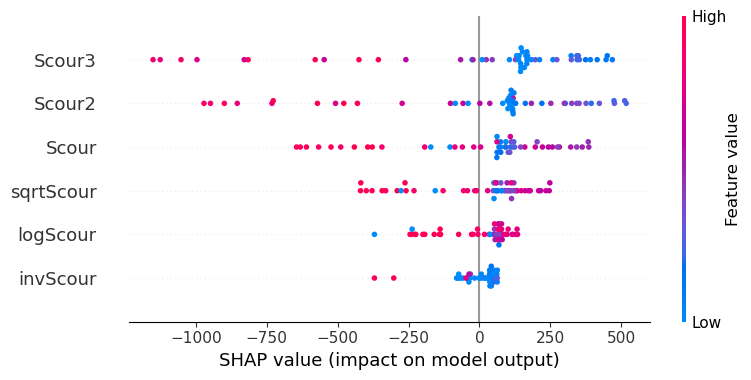

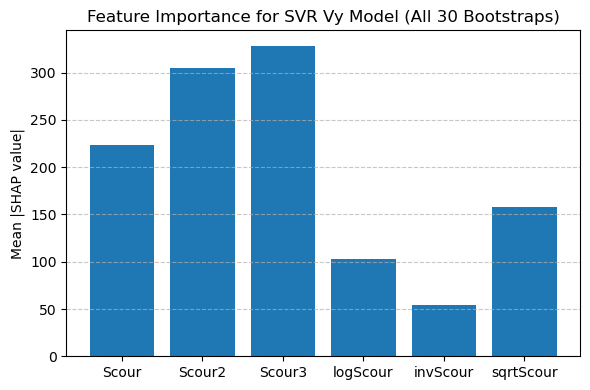

In [68]:
import joblib
import numpy as np
import shap
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths & target ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR")
target = 'Vy'

# --- Load all 30 SVR models & scalers ---
models = [joblib.load(model_folder / f"credal_svr_model_{target}_boot{i}.pkl")
          for i in range(30)]
x_scaler = joblib.load(model_folder / f"x_scaler_{target}.pkl")
y_scaler = joblib.load(model_folder / f"y_scaler_{target}.pkl")

features = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]

# --- Build background & test data in raw space ---
def make_features(sz_m):
    return np.column_stack([
        sz_m*1000,
        (sz_m*1000)**2,
        (sz_m*1000)**3,
        np.log(sz_m*1000),
        1/(sz_m*1000),
        np.sqrt(sz_m*1000)
    ])

sz_bg = np.linspace(0.01,17,100)
Xb = x_scaler.transform(make_features(sz_bg))

sz_ts = np.linspace(0.01,17,50)
Xt = x_scaler.transform(make_features(sz_ts))

# --- New predict fn: median across all 30 models, then inverse‐scale ---
def predict_fn(X_scaled):
    # stack predictions from each bootstrapped SVR
    P = np.vstack([m.predict(X_scaled) for m in models])   # shape (30, n_samples)
    med = np.median(P, axis=0)                             # shape (n_samples,)
    return y_scaler.inverse_transform(med.reshape(-1,1)).ravel()

# --- SHAP Explainer & values ---
explainer = shap.KernelExplainer(predict_fn, Xb)
shap_values = explainer.shap_values(Xt, nsamples=100)

# --- 1) SHAP summary scatter ---
shap.summary_plot(shap_values, Xt, feature_names=features)

# --- 2) SHAP mean‐abs bar chart in your style ---
mean_abs = np.abs(shap_values).mean(axis=0)
plt.figure(figsize=(6,4))
plt.bar(features, mean_abs)
plt.ylabel("Mean |SHAP value|")
plt.title("Feature Importance for SVR Vy Model (All 30 Bootstraps)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


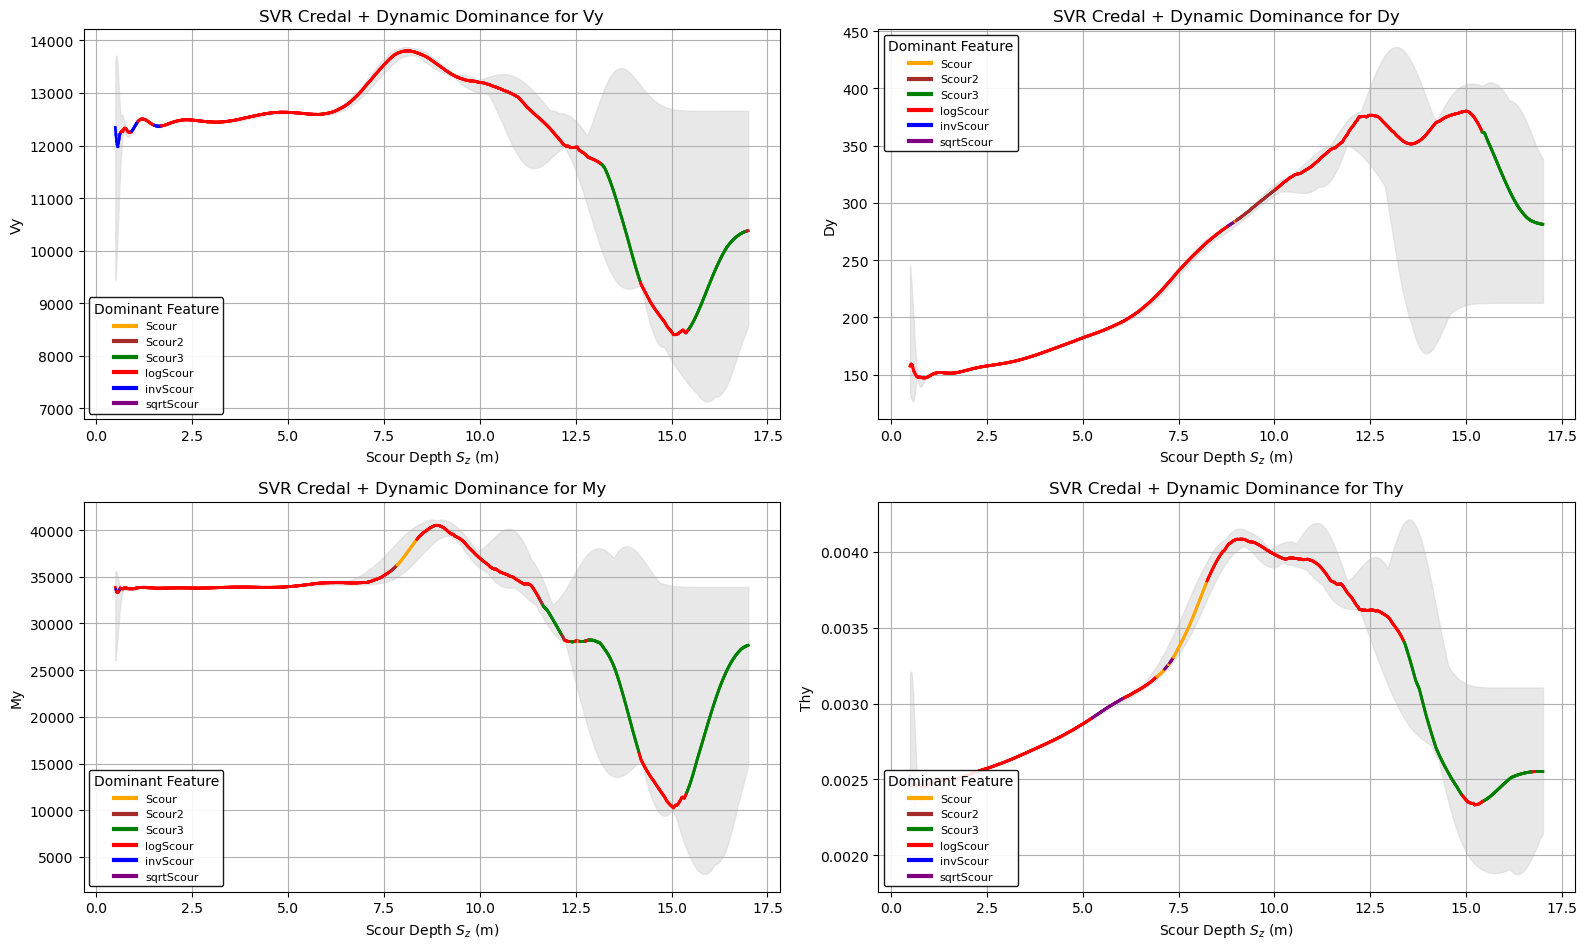

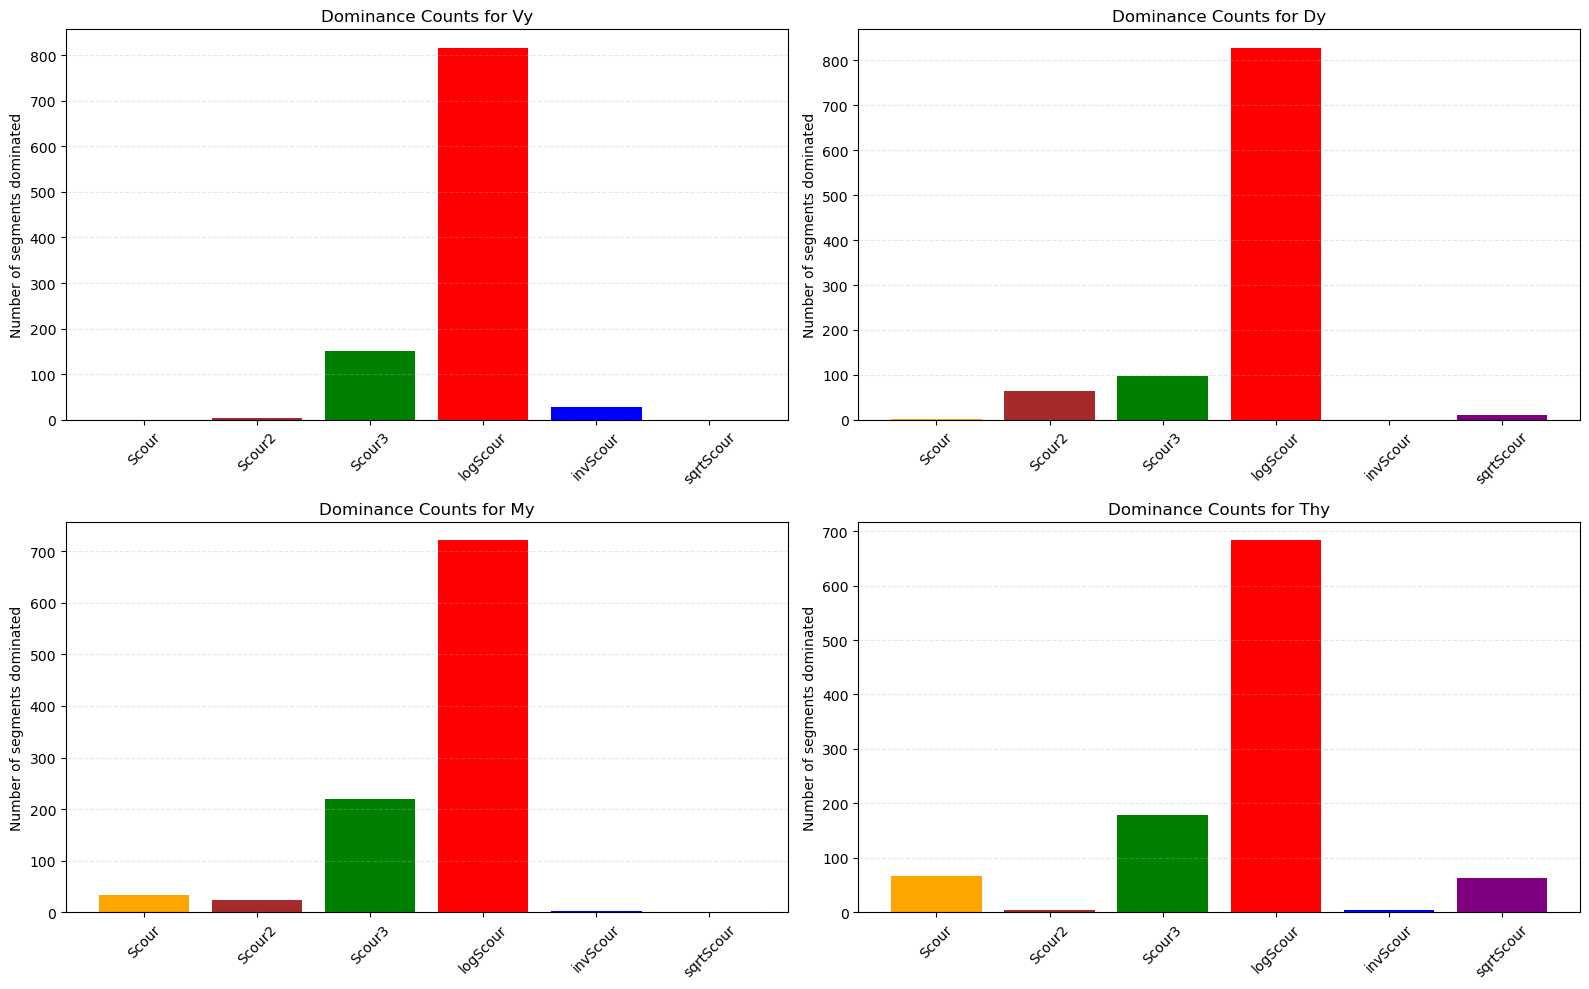

In [25]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from collections import Counter

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR")
targets       = ['Vy','Dy','My','Thy']
features      = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]
feature_colors= {
    "invScour": 'blue',
    "Scour3":   'green',
    "Scour":    'orange',
    "sqrtScour":'purple',
    "Scour2":   'brown',
    "logScour": 'red'
}
perturb = 1.05  # +5%

# --- Precompute scour & raw features ---
sz_m = np.linspace(0.5, 17, 1000)
raw = np.column_stack([
    sz_m*1000,
    (sz_m*1000)**2,
    (sz_m*1000)**3,
    np.log(sz_m*1000),
    1/(sz_m*1000),
    np.sqrt(sz_m*1000)
])

# --- 1) Plot curves and collect dominance lists ---
dom_dict = {}
fig1, axes1 = plt.subplots(2, 2, figsize=(16,10))
axes1 = axes1.ravel()

for ax, target in zip(axes1, targets):
    # load scalers + all 30 SVR bootstraps
    x_s = joblib.load(model_folder / f"x_scaler_{target}.pkl")
    y_s = joblib.load(model_folder / f"y_scaler_{target}.pkl")
    models = [
        joblib.load(model_folder / f"credal_svr_model_{target}_boot{i}.pkl")
        for i in range(30)
    ]

    # scale and predict
    Xs = x_s.transform(raw)
    all_preds = np.stack([
        y_s.inverse_transform(m.predict(Xs).reshape(-1,1)).ravel()
        for m in models
    ], axis=0)
    pred_lo, pred_hi = all_preds.min(axis=0), all_preds.max(axis=0)
    pred_med        = np.median(all_preds, axis=0)

    # dynamic dominance
    dom = []
    for i in range(len(sz_m)):
        b_raw  = raw[i].reshape(1,-1)
        b_s    = x_s.transform(b_raw)
        base   = np.median([m.predict(b_s)[0] for m in models])
        base_r = y_s.inverse_transform([[base]])[0,0]

        deltas = []
        for j in range(len(features)):
            p_raw = b_raw.copy()
            p_raw[0,j] *= perturb
            p_s   = x_s.transform(p_raw)
            p_med = np.median([m.predict(p_s)[0] for m in models])
            p_r   = y_s.inverse_transform([[p_med]])[0,0]
            deltas.append(abs(p_r - base_r))
        dom.append(features[np.argmax(deltas)])

    dom_dict[target] = dom

    # plot credal band
    ax.fill_between(sz_m, pred_lo, pred_hi,
                    color='lightgray', alpha=0.5, zorder=1)

    # plot median segments colored by dominant feature
    for i in range(len(sz_m)-1):
        c = feature_colors[dom[i]]
        ax.plot(sz_m[i:i+2], pred_med[i:i+2],
                color=c, lw=2, zorder=2)

    # decorations
    ax.set_title(f"SVR Credal + Dynamic Dominance for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(target)
    ax.grid(True)

    # conditional legend placement: move only Dy to upper left
    legend_elems = [
        Line2D([0],[0], color=feature_colors[f], lw=3, label=f)
        for f in features
    ]
    loc = 'upper left' if target == 'Dy' else 'lower left'
    ax.legend(handles=legend_elems,
              title="Dominant Feature",
              loc=loc,
              frameon=True, fancybox=True,
              edgecolor="black",
              fontsize=8, framealpha=0.9)

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# --- 2) Plot bar‐charts of dominance counts ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16,10))
axes2 = axes2.ravel()

for ax, target in zip(axes2, targets):
    counts = Counter(dom_dict[target])
    values = [counts[f] for f in features]

    ax.bar(range(len(features)), values,
           color=[feature_colors[f] for f in features])
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45)
    ax.set_title(f"Dominance Counts for {target}")
    ax.set_ylabel("Number of segments dominated")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


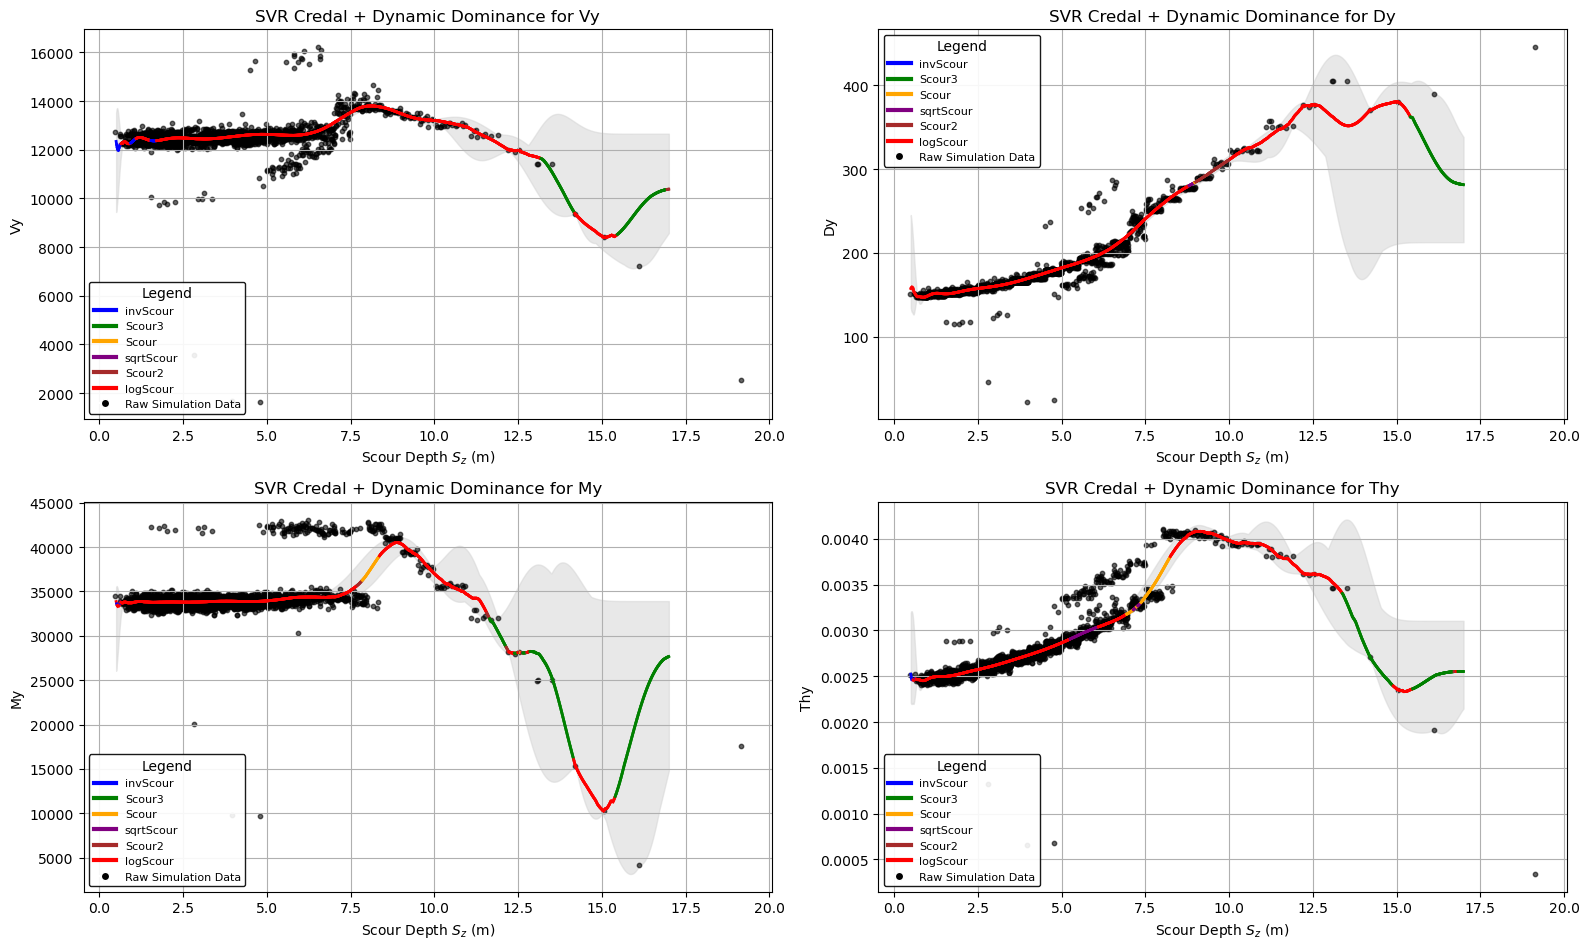

In [26]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

# --- Configuration ---
model_folder  = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR")
raw_data_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
targets        = ['Vy','Dy','My','Thy']
raw_cols       = ['Vy_kN','dy_mm','My_kNm','Thy_rad']
features       = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]
feature_colors = {
    "invScour": 'blue',
    "Scour3":   'green',
    "Scour":    'orange',
    "sqrtScour":'purple',
    "Scour2":   'brown',
    "logScour": 'red'
}
perturb = 1.05  # +5%

# --- Load raw data ---
df_raw = pd.concat(pd.read_excel(raw_data_path, sheet_name=None), ignore_index=True)

# --- Precompute scour & raw features ---
sz_m = np.linspace(0.5,17,1000)
raw_feats = np.column_stack([
    sz_m*1000,
    (sz_m*1000)**2,
    (sz_m*1000)**3,
    np.log(sz_m*1000),
    1/(sz_m*1000),
    np.sqrt(sz_m*1000)
])

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(16,10))
axes = axes.ravel()

for ax, target, raw_col in zip(axes, targets, raw_cols):
    # load scalers + all 30 SVR models
    x_s = joblib.load(model_folder/f"x_scaler_{target}.pkl")
    y_s = joblib.load(model_folder/f"y_scaler_{target}.pkl")
    models = [
        joblib.load(model_folder/f"credal_svr_model_{target}_boot{i}.pkl")
        for i in range(30)
    ]

    # scale once
    X = x_s.transform(raw_feats)

    # ensemble preds
    all_preds = np.stack([
        y_s.inverse_transform(m.predict(X).reshape(-1,1)).ravel()
        for m in models
    ], axis=0)
    pred_lo  = all_preds.min(axis=0)
    pred_hi  = all_preds.max(axis=0)
    pred_med = np.median(all_preds, axis=0)

    # dynamic feature dominance
    dom = []
    for i in range(len(sz_m)):
        b_raw = raw_feats[i].reshape(1,-1)
        b_s   = x_s.transform(b_raw)
        base  = np.median([m.predict(b_s)[0] for m in models])
        base_r= y_s.inverse_transform([[base]])[0,0]

        deltas = []
        for j in range(len(features)):
            p = b_raw.copy()
            p[0,j] *= perturb
            ps = x_s.transform(p)
            pp = np.median([m.predict(ps)[0] for m in models])
            pr = y_s.inverse_transform([[pp]])[0,0]
            deltas.append(abs(pr-base_r))
        dom.append(features[np.argmax(deltas)])

    # plot credal band
    ax.fill_between(sz_m, pred_lo, pred_hi, color='lightgray', alpha=0.5, zorder=1)

    # plot median colored by dominant feature
    for i in range(len(sz_m)-1):
        c = feature_colors[dom[i]]
        ax.plot(sz_m[i:i+2], pred_med[i:i+2], color=c, lw=2, zorder=2)

    # overlay raw data points
    ax.scatter(
        df_raw["Scour_Depth_mm"]/1000,
        df_raw[raw_col],
        color='black', s=10, alpha=0.6,
        label="Raw Simulation Data"
    )

    # decorations
    ax.set_title(f"SVR Credal + Dynamic Dominance for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(target)
    ax.grid(True)

    # conditional legend placement
    legend_patches = [
        Line2D([0],[0], color=color, lw=3, label=feat)
        for feat, color in feature_colors.items()
    ] + [
        Line2D([0],[0], marker='o', color='w', markerfacecolor='black',
               markersize=6, label='Raw Simulation Data')
    ]
    loc = 'upper left' if target == 'Dy' else 'lower left'
    ax.legend(
        handles=legend_patches,
        title="Legend",
        loc=loc,
        frameon=True,
        fancybox=True,
        edgecolor="black",
        fontsize=8,
        framealpha=0.9
    )

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [96]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from datetime import datetime

# --------------------------
# Configuration
# --------------------------
input_folder = Path("RecorderData/results")
model_folder = input_folder / "Tuple_Data_Process" / "ML_Surrogate_Improved"
output_folder = input_folder / "SurrogatePredictions"
output_folder.mkdir(parents=True, exist_ok=True)

# Load latest LHS scour depth input file
lhs_scor_file = list(input_folder.glob("LHS_Scour_Depths_*.xlsx"))
if not lhs_scor_file:
    raise FileNotFoundError("❌ No LHS_Scour_Depths_*.xlsx found.")
lhs_scor_file = max(lhs_scor_file, key=lambda f: f.stat().st_mtime)
print(f"📂 Using LHS Scour Depths File: {lhs_scor_file.name}")

lhs_sheets = pd.read_excel(lhs_scor_file, sheet_name=None)

# --------------------------
# Load Trained Models
# --------------------------
model_vy = joblib.load(model_folder / "model_Vy.pkl")
model_dy = joblib.load(model_folder / "model_Dy.pkl")
model_my = joblib.load(model_folder / "model_My.pkl")
model_thy = joblib.load(model_folder / "model_Thy.pkl")

# --------------------------
# Batch Prediction
# --------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = output_folder / f"Predicted_LHS_CapacityTuples_{timestamp}.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for sheet_name, df in lhs_sheets.items():
        print(f"🔄 Processing: {sheet_name}")
        
        # Extract Scour Depths (direct from the file)
        scour = np.clip(df["Scour_Depth_mm"].values, None, 20000)

        # Prepare the input data for the trained model
        X_new = np.column_stack([
            scour,
            scour**2,
            scour**3,
            np.log(scour),
            1 / scour,
            np.sqrt(scour)
        ])

        # Predict using the trained models
        df_out = pd.DataFrame({
            "Sample_Index": df["Sample_Index"].values,
            "Scour_Depth_mm": scour,
            "Predicted_Vy_kN": model_vy.predict(X_new),
            "Predicted_Dy_mm": model_dy.predict(X_new),
            "Predicted_My_kNm": model_my.predict(X_new),
            "Predicted_Thy_rad": model_thy.predict(X_new)
        })

        # Save predictions to the new file
        df_out.to_excel(writer, sheet_name=sheet_name[:31], index=False)

print(f"✅ Batch prediction completed.\n📁 Output saved to: {output_file}")


📂 Using LHS Scour Depths File: LHS_Scour_Depths_20250406_113647.xlsx
🔄 Processing: Scenario_1_Missouri_River
🔄 Processing: Scenario_2_Colorado_River
🔄 Processing: Scenario_3_Extreme_Case
✅ Batch prediction completed.
📁 Output saved to: RecorderData\results\SurrogatePredictions\Predicted_LHS_CapacityTuples_20250406_140755.xlsx


📊 Using predicted file: Predicted_LHS_CapacityTuples_20250406_140755.xlsx
📂 Using actual LHS data: LHS_Bilinear_CapacityTuples_20250406_121118.xlsx
📈 Plotting for scenario: Scenario_1_Missouri_River


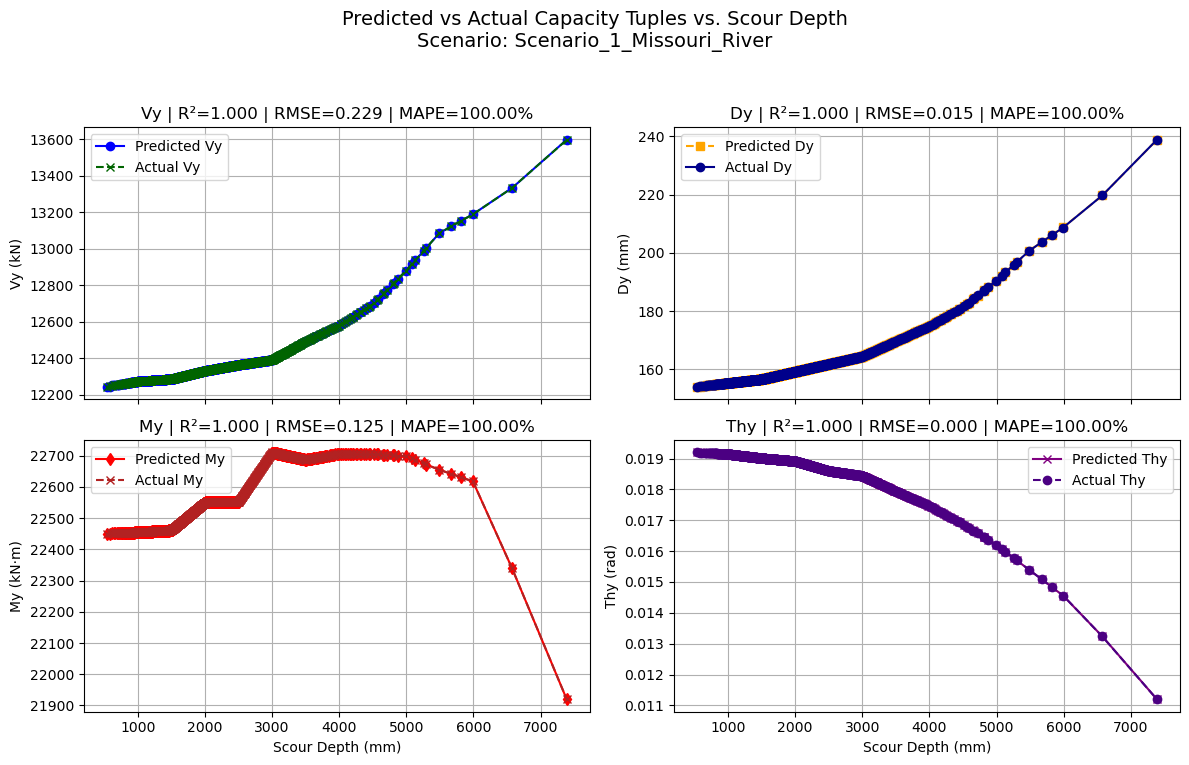

✅ Plot saved to: RecorderData\results\tuple_prediction_comparison_Scenario_1_Missouri_River.png
📈 Plotting for scenario: Scenario_2_Colorado_River


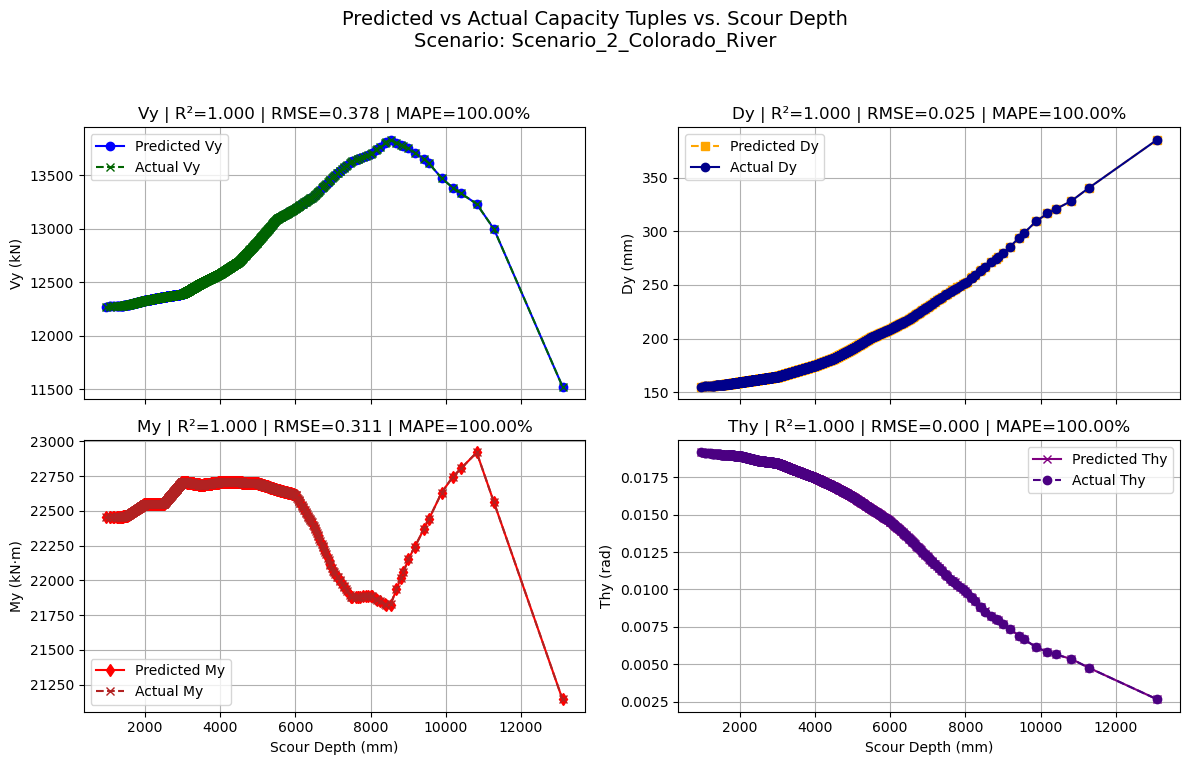

✅ Plot saved to: RecorderData\results\tuple_prediction_comparison_Scenario_2_Colorado_River.png
📈 Plotting for scenario: Scenario_3_Extreme_Case


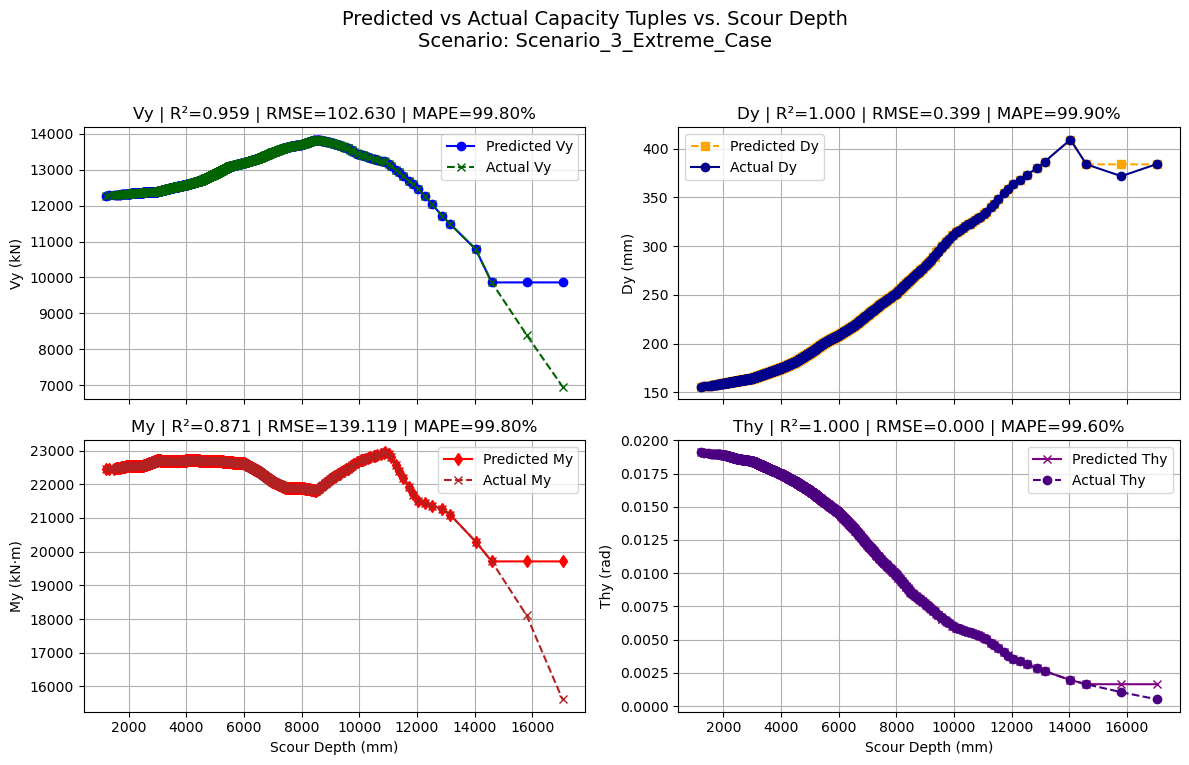

✅ Plot saved to: RecorderData\results\tuple_prediction_comparison_Scenario_3_Extreme_Case.png


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error

# --- CONFIGURATION ---
actual_results_folder = Path("RecorderData/results")  # Folder containing actual data
predicted_results_folder = Path("RecorderData/results/SurrogatePredictions")  # Folder containing predicted data

# --- Load Latest Predicted Results ---
predicted_files = list(predicted_results_folder.glob("Predicted_LHS_CapacityTuples_*.xlsx"))
if not predicted_files:
    raise FileNotFoundError("No predicted LHS results found.")
latest_predicted_file = max(predicted_files, key=os.path.getmtime)
print(f"📊 Using predicted file: {latest_predicted_file.name}")

# Load all sheets from the predicted file
predicted_data = pd.read_excel(latest_predicted_file, sheet_name=None)

# --- Load Latest Actual Results ---
actual_files = list(actual_results_folder.glob("LHS_Bilinear_CapacityTuples_*.xlsx"))
if not actual_files:
    raise FileNotFoundError("No actual LHS results found.")
latest_actual_file = max(actual_files, key=lambda f: f.stat().st_mtime)
print(f"📂 Using actual LHS data: {latest_actual_file.name}")

# Load all sheets from the actual file
actual_sheets = pd.read_excel(latest_actual_file, sheet_name=None)

# --- Loop through each scenario/sheet ---
for sheet_name, predicted_df in predicted_data.items():
    print(f"📈 Plotting for scenario: {sheet_name}")

    # Ensure the actual data corresponds to the same sheet
    actual_df = actual_sheets.get(sheet_name)
    if actual_df is None:
        print(f"⚠️ No actual data for {sheet_name}, skipping...")
        continue

    # Sort values by Scour Depth for consistency
    predicted_df = predicted_df.sort_values(by="Scour_Depth_mm")
    actual_df = actual_df.sort_values(by="Scour_Depth_mm")

    # Setup subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # --- Subplot 1: Vy ---
    actual_values = actual_df["Vy (kN)"].values  # Actual values from the actual file
    predicted_values = predicted_df["Predicted_Vy_kN"].values  # Predicted values from the predicted file
    r2 = r2_score(actual_values, predicted_values)
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    
    # Calculate MAPE based on same values (within a tolerance of 1% of the actual value)
    tolerance = 0.01  # 1% tolerance
    same_count = np.sum(np.abs(actual_values - predicted_values) <= tolerance * actual_values)
    mape = (same_count / len(actual_values)) * 100  # percentage of same values within tolerance
    
    axs[0, 0].plot(predicted_df["Scour_Depth_mm"], predicted_values, 'o-', color='blue', label="Predicted Vy")
    axs[0, 0].plot(actual_df["Scour_Depth_mm"], actual_values, 'x--', color='darkgreen', label="Actual Vy")
    axs[0, 0].set_ylabel("Vy (kN)")
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    axs[0, 0].set_title(f"Vy | R²={r2:.3f} | RMSE={rmse:.3f} | MAPE={mape:.2f}%")

    # --- Subplot 2: Dy ---
    actual_values = actual_df["Δy (mm)"].values  # Actual values from the actual file
    predicted_values = predicted_df["Predicted_Dy_mm"].values  # Predicted values from the predicted file
    r2 = r2_score(actual_values, predicted_values)
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    
    # Calculate MAPE for Dy
    same_count = np.sum(np.abs(actual_values - predicted_values) <= tolerance * actual_values)
    mape = (same_count / len(actual_values)) * 100
    
    axs[0, 1].plot(predicted_df["Scour_Depth_mm"], predicted_values, 's--', color='orange', label="Predicted Dy")
    axs[0, 1].plot(actual_df["Scour_Depth_mm"], actual_values, 'o-', color='darkblue', label="Actual Dy")
    axs[0, 1].set_ylabel("Dy (mm)")
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    axs[0, 1].set_title(f"Dy | R²={r2:.3f} | RMSE={rmse:.3f} | MAPE={mape:.2f}%")

    # --- Subplot 3: My ---
    actual_values = actual_df["My (kN·m)"].values  # Actual values from the actual file
    predicted_values = predicted_df["Predicted_My_kNm"].values  # Predicted values from the predicted file
    r2 = r2_score(actual_values, predicted_values)
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    
    # Calculate MAPE for My
    same_count = np.sum(np.abs(actual_values - predicted_values) <= tolerance * actual_values)
    mape = (same_count / len(actual_values)) * 100
    
    axs[1, 0].plot(predicted_df["Scour_Depth_mm"], predicted_values, 'd-', color='red', label="Predicted My")
    axs[1, 0].plot(actual_df["Scour_Depth_mm"], actual_values, 'x--', color='firebrick', label="Actual My")
    axs[1, 0].set_ylabel("My (kN·m)")
    axs[1, 0].set_xlabel("Scour Depth (mm)")
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    axs[1, 0].set_title(f"My | R²={r2:.3f} | RMSE={rmse:.3f} | MAPE={mape:.2f}%")

    # --- Subplot 4: Thy ---
    actual_values = actual_df["Θy (rad)"].values  # Actual values from the actual file
    predicted_values = predicted_df["Predicted_Thy_rad"].values  # Predicted values from the predicted file
    r2 = r2_score(actual_values, predicted_values)
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    
    # Calculate MAPE for Thy
    same_count = np.sum(np.abs(actual_values - predicted_values) <= tolerance * actual_values)
    mape = (same_count / len(actual_values)) * 100
    
    axs[1, 1].plot(predicted_df["Scour_Depth_mm"], predicted_values, 'x-', color='purple', label="Predicted Thy")
    axs[1, 1].plot(actual_df["Scour_Depth_mm"], actual_values, 'o--', color='indigo', label="Actual Thy")
    axs[1, 1].set_ylabel("Thy (rad)")
    axs[1, 1].set_xlabel("Scour Depth (mm)")
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    axs[1, 1].set_title(f"Thy | R²={r2:.3f} | RMSE={rmse:.3f} | MAPE={mape:.2f}%")

    # Title & layout
    plt.suptitle(f"Predicted vs Actual Capacity Tuples vs. Scour Depth\nScenario: {sheet_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save to file
    safe_name = sheet_name.replace(" ", "_").replace(":", "_")
    output_path = results_folder / f"tuple_prediction_comparison_{safe_name}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Plot saved to: {output_path}")


In [116]:
import joblib
import numpy as np

# Load the saved models
model_vy = joblib.load("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Improved/model_Vy.pkl")
model_dy = joblib.load("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Improved/model_Dy.pkl")
model_my = joblib.load("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Improved/model_My.pkl")
model_thy = joblib.load("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Improved/model_Thy.pkl")

# Function to predict values based on scour depth
def predict_values(scour_depth):
    # Prepare features
    scour = np.array([scour_depth])
    features = np.column_stack([
        scour,
        scour**2,
        scour**3,
        np.log(scour),
        1 / scour,
        np.sqrt(scour)
    ])

    # Predict using the models
    vy_pred = model_vy.predict(features)
    dy_pred = model_dy.predict(features)
    my_pred = model_my.predict(features)
    thy_pred = model_thy.predict(features)

    return vy_pred[0], dy_pred[0], my_pred[0], thy_pred[0]

# Example usage: Predicting for a scour depth of 1500 mm
scour_depth = 1500  # Example scour depth in mm
vy, dy, my, thy = predict_values(scour_depth)

print(f"Predicted Vy: {vy} kN")
print(f"Predicted Dy: {dy} mm")
print(f"Predicted My: {my} kN·m")
print(f"Predicted Thy: {thy} rad")


Predicted Vy: 12278.901061628516 kN
Predicted Dy: 156.46700102298504 mm
Predicted My: 22459.499238068398 kN·m
Predicted Thy: 0.019019072796540946 rad


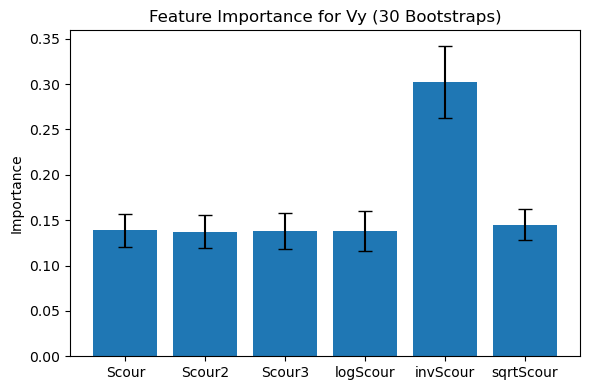

Predictions for Scour=500 mm across 30 models:
  min = 12365.31 kN
  median = 12444.08 kN
  max = 12516.64 kN


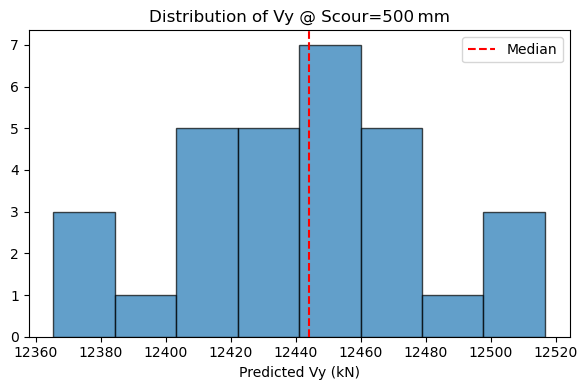

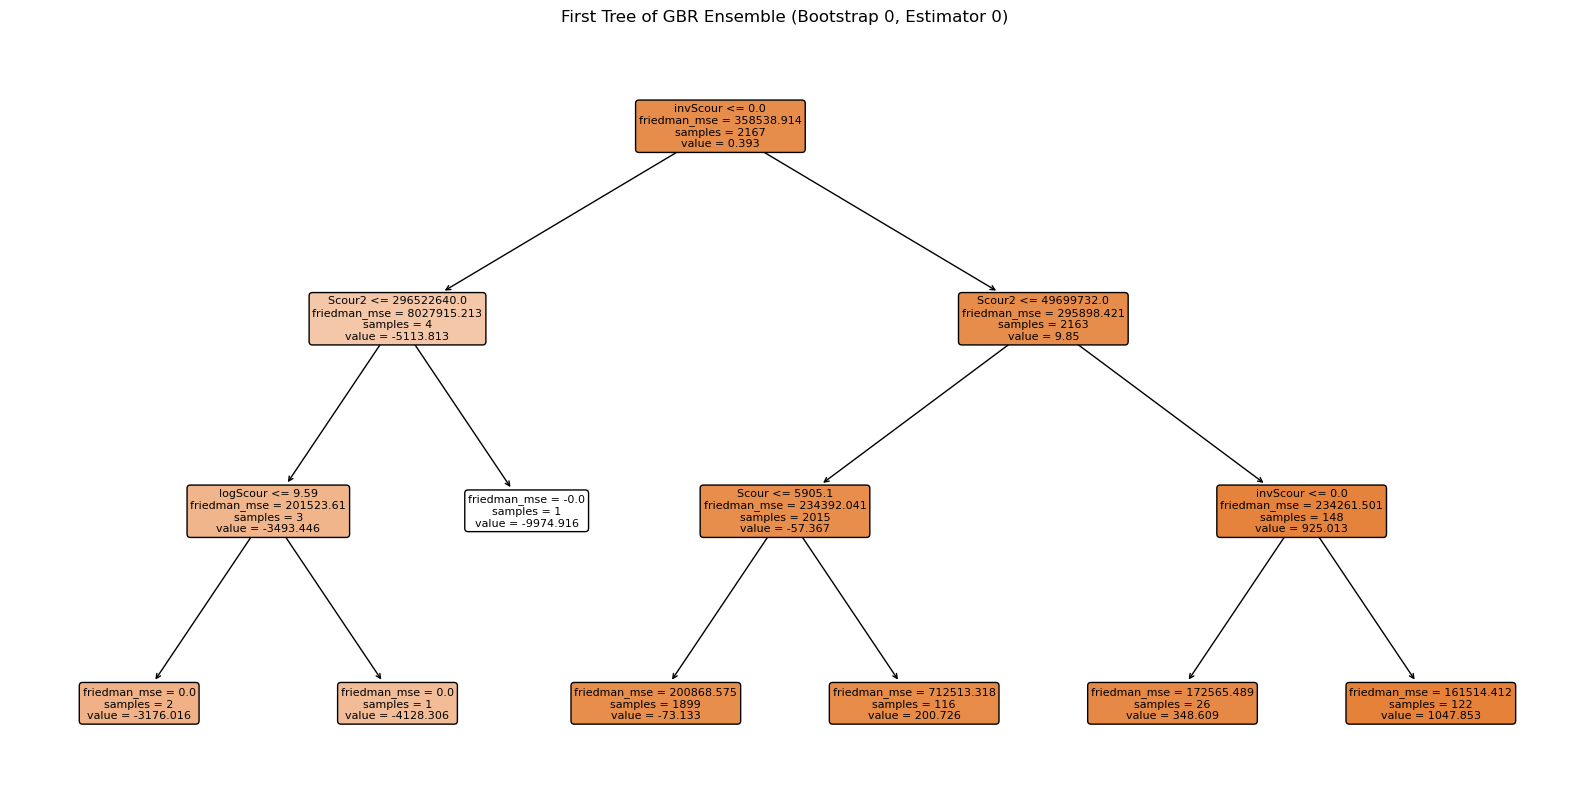

In [9]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import tree

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_raw")
target = "Vy"
n_boot = 30
features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]

# --- Load all 30 models ---
models = [
    joblib.load(model_folder / f"credal_model_{target}_boot{i}_raw.pkl")
    for i in range(n_boot)
]

# --- 1) Combined Feature Importance (mean ± std) ---
importances = np.vstack([m.feature_importances_ for m in models])  # shape (30,6)
mean_imp = importances.mean(axis=0)
std_imp  = importances.std(axis=0)

plt.figure(figsize=(6,4))
plt.bar(features, mean_imp, yerr=std_imp, capsize=5)
plt.ylabel("Importance")
plt.title(f"Feature Importance for {target} (30 Bootstraps)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2) Sample Prediction Distribution @ Scour=500 mm ---
sz = 500
sample = np.array([[sz, sz**2, sz**3, np.log(sz), 1/sz, np.sqrt(sz)]])

# gather all predictions
preds = np.array([m.predict(sample)[0] for m in models])
print(f"Predictions for Scour={sz} mm across 30 models:")
print(f"  min = {preds.min():.2f} kN")
print(f"  median = {np.median(preds):.2f} kN")
print(f"  max = {preds.max():.2f} kN")

# optional: histogram of the 30 predictions
plt.figure(figsize=(6,4))
plt.hist(preds, bins=8, edgecolor="k", alpha=0.7)
plt.axvline(np.median(preds), color='r', linestyle='--', label="Median")
plt.xlabel(f"Predicted {target} (kN)")
plt.title(f"Distribution of {target} @ Scour={sz} mm")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3) Visualize the first tree of the first bootstrap ---
plt.figure(figsize=(20,10))
tree.plot_tree(
    models[0].estimators_[0,0],
    filled=True,
    feature_names=features,
    rounded=True,
    fontsize=8
)
plt.title("First Tree of GBR Ensemble (Bootstrap 0, Estimator 0)")
plt.show()


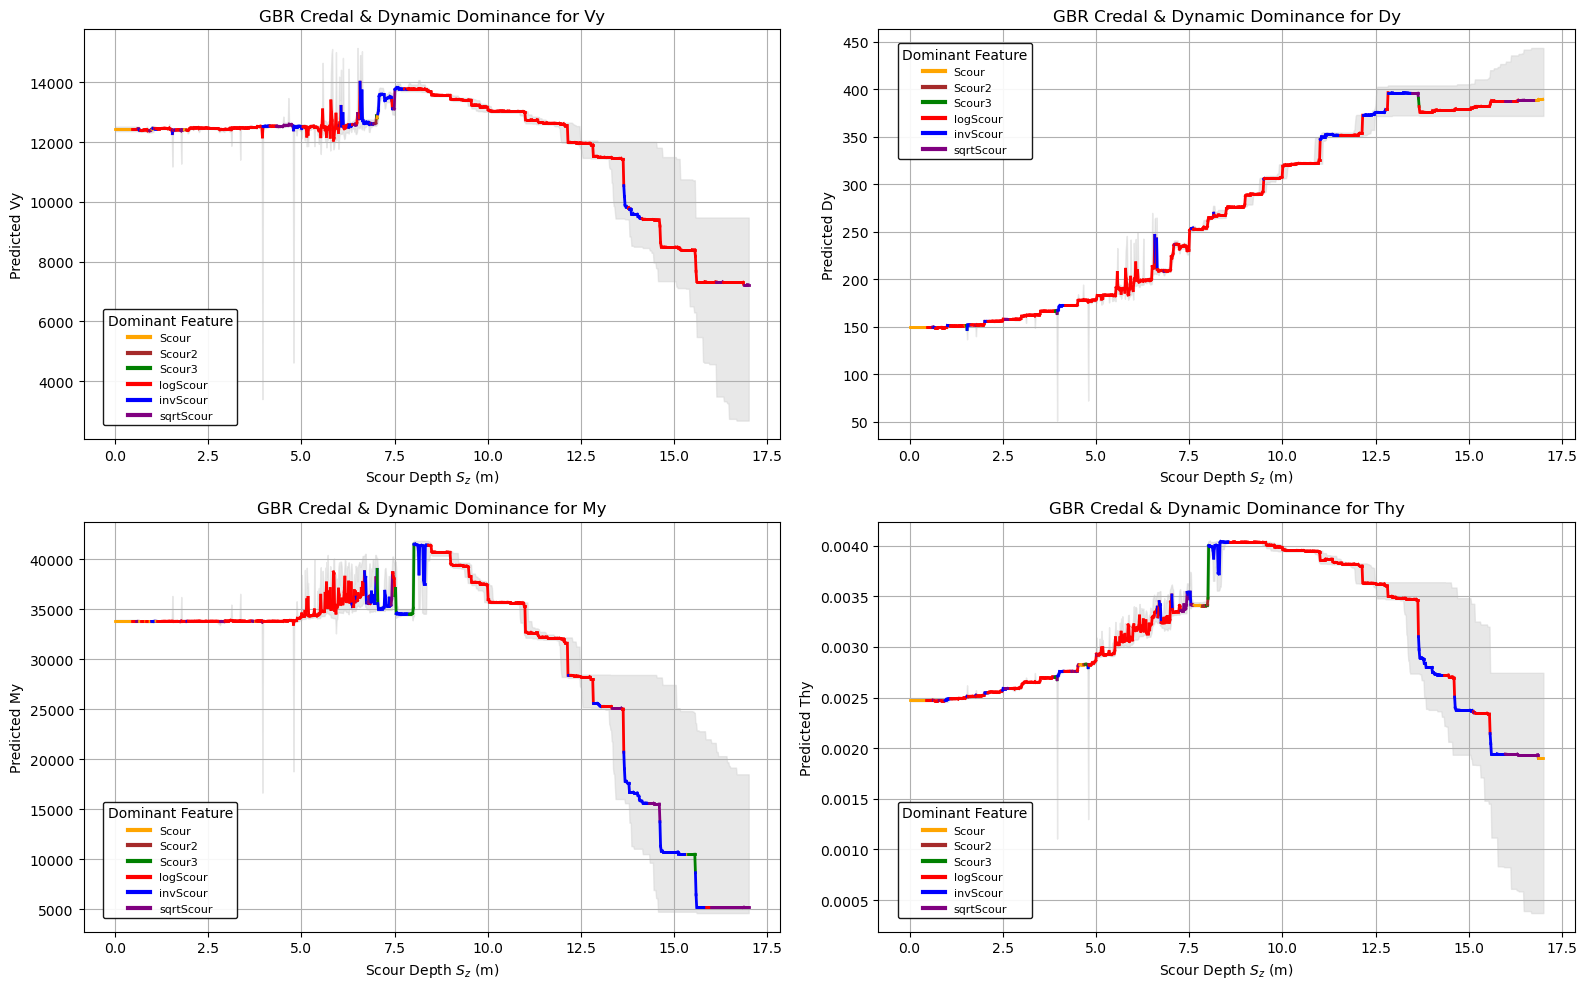

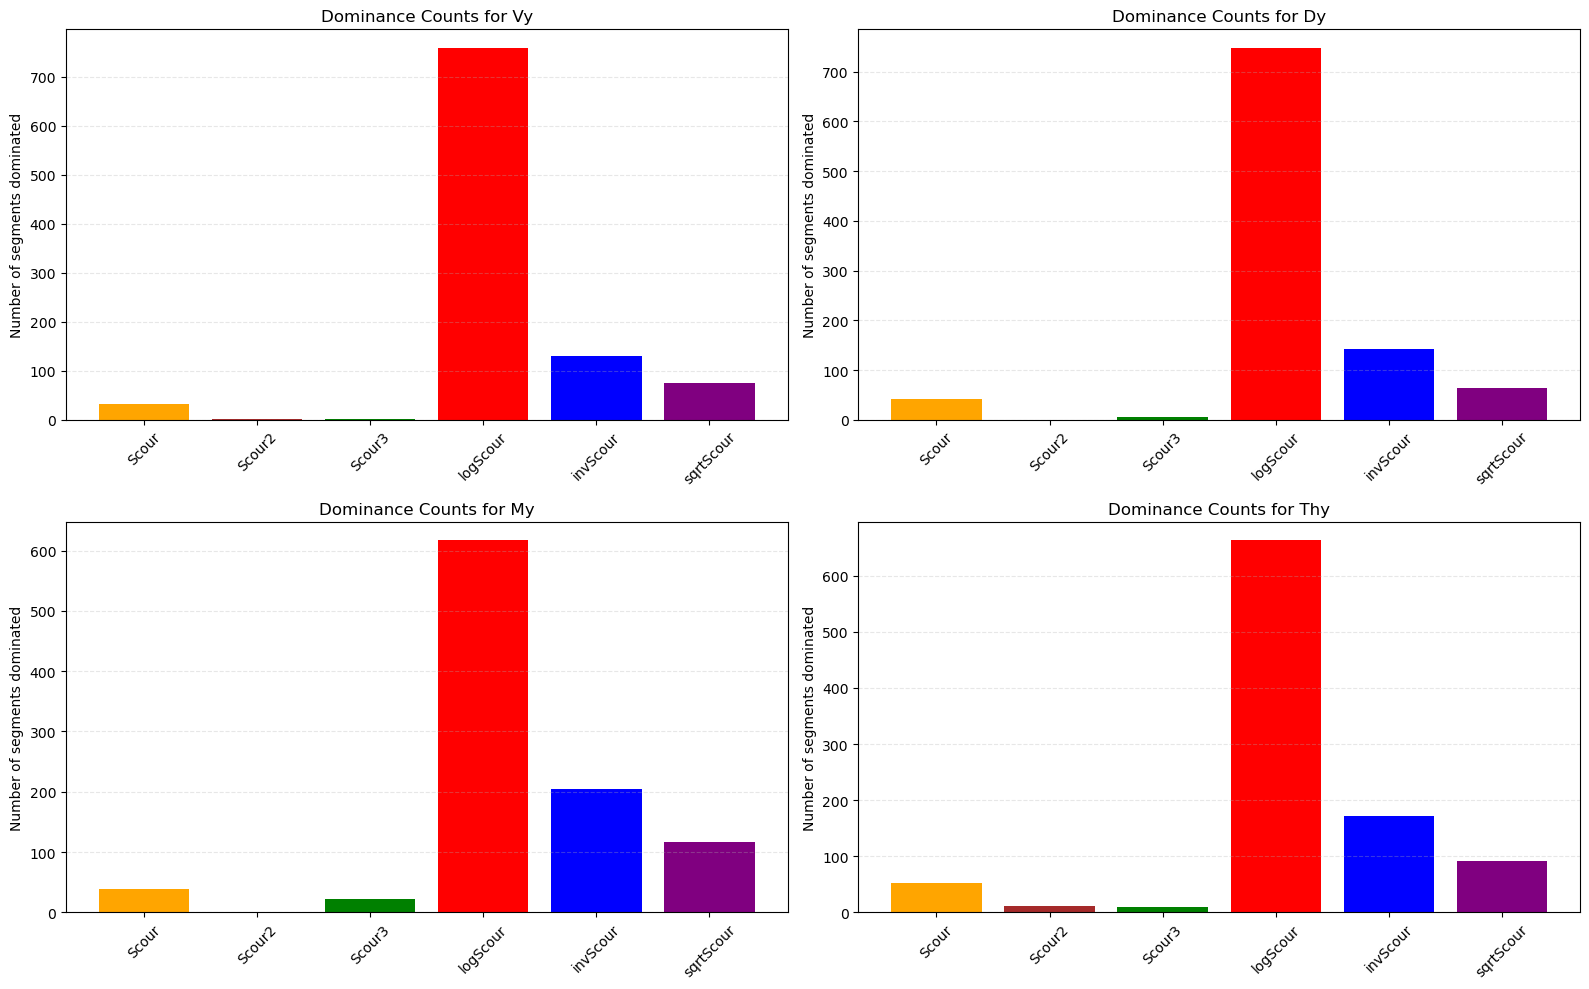

In [11]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from collections import Counter

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_raw")
output_path_dir = model_folder / "Figures"
output_path_dir.mkdir(parents=True, exist_ok=True)

targets = ['Vy','Dy','My','Thy']
features = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]
feature_colors = {
    "Scour":    'orange',
    "Scour2":   'brown',
    "Scour3":   'green',
    "logScour": 'red',
    "invScour": 'blue',
    "sqrtScour":'purple'
}
perturb = 1.05  # +5%

# --- Build scour vector & engineered inputs ---
sz_m = np.linspace(0.01,17,1000)
X_raw = np.column_stack([
    sz_m*1000,
    (sz_m*1000)**2,
    (sz_m*1000)**3,
    np.log(sz_m*1000),
    1/(sz_m*1000),
    np.sqrt(sz_m*1000)
])

# --- 1) Plot dynamic-dominance curves and collect dom lists ---
dom_dict = {}
fig1, axes1 = plt.subplots(2,2,figsize=(16,10))
axes1 = axes1.ravel()

for ax, target in zip(axes1, targets):
    models = [joblib.load(model_folder/f"credal_model_{target}_boot{i}_raw.pkl") for i in range(30)]
    all_preds = np.stack([m.predict(X_raw) for m in models], axis=0)
    pred_lo, pred_hi = all_preds.min(axis=0), all_preds.max(axis=0)
    pred_med = np.median(all_preds, axis=0)

    dom = []
    for i in range(len(sz_m)):
        base = X_raw[i:i+1,:]
        med_val = np.median([m.predict(base)[0] for m in models])
        deltas = []
        for j in range(len(features)):
            p = base.copy()
            p[0,j] *= perturb
            pert = np.median([m.predict(p)[0] for m in models])
            deltas.append(abs(pert - med_val))
        dom.append(features[np.argmax(deltas)])
    dom_dict[target] = dom

    ax.fill_between(sz_m, pred_lo, pred_hi, color='lightgray', alpha=0.5, zorder=1)
    for i in range(len(sz_m)-1):
        ax.plot(sz_m[i:i+2], pred_med[i:i+2],
                color=feature_colors[dom[i]], lw=2, zorder=2)

    ax.set_title(f"GBR Credal & Dynamic Dominance for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(f"Predicted {target}")
    ax.grid(True)

    legend_elems = [Line2D([0],[0], color=feature_colors[f], lw=3, label=f) for f in features]
    loc = 'upper left' if target=='Dy' else 'lower left'
    bbox = (0.02,0.98) if target=='Dy' else (0.02,0.02)
    ax.legend(handles=legend_elems, title="Dominant Feature",
              loc=loc, bbox_to_anchor=bbox,
              frameon=True, fancybox=True, edgecolor="black",
              fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig(output_path_dir / "Figure12.pdf")
plt.savefig(output_path_dir / "CredalRaw_DynamicDominance_Multiplot.png", dpi=300)
plt.show()

# --- 2) Plot bar-charts of dominance counts for each target ---
fig2, axes2 = plt.subplots(2,2,figsize=(16,10))
axes2 = axes2.ravel()

for ax, target in zip(axes2, targets):
    counts = Counter(dom_dict[target])
    values = [counts[f] for f in features]

    ax.bar(range(len(features)), values,
           color=[feature_colors[f] for f in features])
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45)
    ax.set_title(f"Dominance Counts for {target}")
    ax.set_ylabel("Number of segments dominated")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(output_path_dir / "Figure13.pdf")
plt.savefig(output_path_dir / "CredalRaw_FeatureDominance_Barcharts.png", dpi=300)
plt.show()


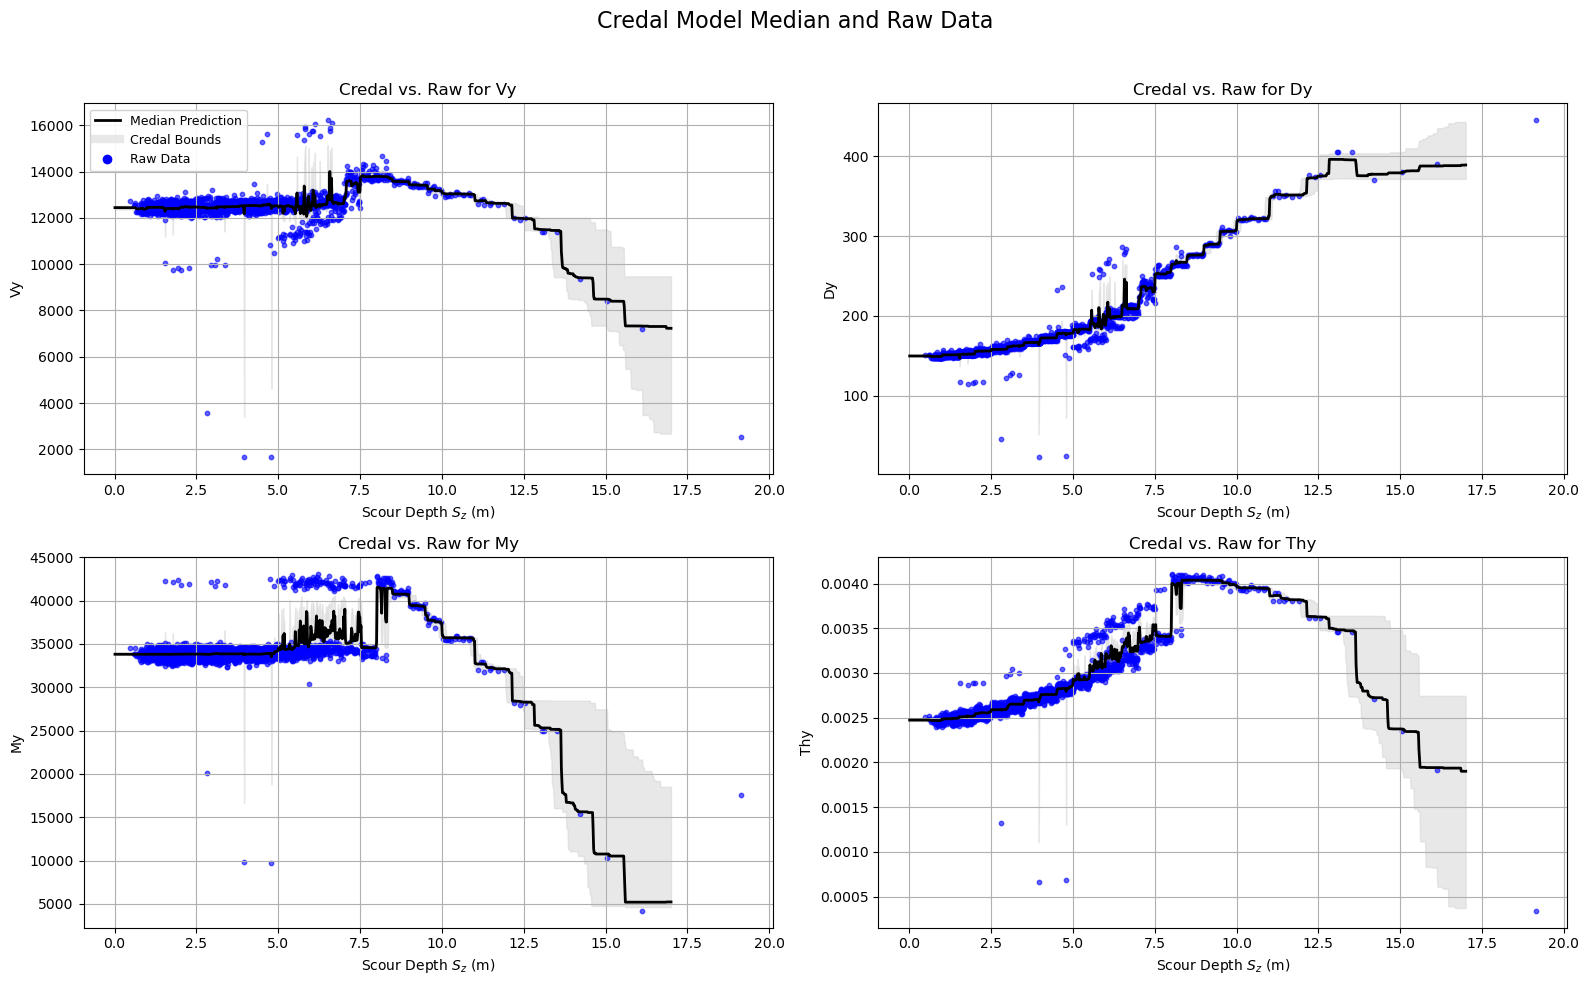

In [12]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- Setup ---
model_folder   = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_raw")
raw_data_path  = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
output_path_dir = model_folder / "Figures"
output_path_dir.mkdir(parents=True, exist_ok=True)

targets        = ['Vy', 'Dy', 'My', 'Thy']
raw_columns    = ['Vy_kN', 'dy_mm', 'My_kNm', 'Thy_rad']

# --- Build scour vector & features matrix ---
sz_m = np.linspace(0.01, 17, 1000)
X_raw = np.column_stack([
    sz_m * 1000,              # Scour in mm
    (sz_m * 1000) ** 2,       # Scour^2
    (sz_m * 1000) ** 3,       # Scour^3
    np.log(sz_m * 1000),      # log(Scour)
    1 / (sz_m * 1000),        # invScour
    np.sqrt(sz_m * 1000)      # sqrtScour
])

# --- Load raw scatter data once ---
df_raw = pd.concat(pd.read_excel(raw_data_path, sheet_name=None), ignore_index=True)

# --- Prepare figure ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

for ax, target, raw_col in zip(axs, targets, raw_columns):
    # Load 30 bootstrapped models and predict
    models = [joblib.load(model_folder / f"credal_model_{target}_boot{i}_raw.pkl") for i in range(30)]
    all_preds = np.stack([m.predict(X_raw) for m in models], axis=0)
    y_lo = all_preds.min(axis=0)
    y_hi = all_preds.max(axis=0)
    y_med = np.median(all_preds, axis=0)

    # Plot prediction bounds and median
    ax.fill_between(sz_m, y_lo, y_hi, color='lightgray', alpha=0.5, label="Credal Bounds")
    ax.plot(sz_m, y_med, color='black', lw=2, label="Median Prediction")

    # Overlay raw data
    ax.scatter(df_raw["Scour_Depth_mm"] / 1000, df_raw[raw_col],
               color='blue', s=10, alpha=0.6, label="Raw Data")

    ax.set_title(f"Credal vs. Raw for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(f"{target}")
    ax.grid(True)

# Legend on top-left
handles = [
    plt.Line2D([0], [0], color='black', lw=2, label='Median Prediction'),
    plt.Line2D([0], [0], color='lightgray', lw=6, alpha=0.5, label='Credal Bounds'),
    plt.Line2D([0], [0], marker='o', color='blue', linestyle='', markersize=6, label='Raw Data')
]
axs[0].legend(handles=handles, loc='upper left', fontsize=9, framealpha=0.9)

plt.suptitle("Credal Model Median and Raw Data", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save before showing
plt.savefig(output_path_dir / "Figure14.pdf")
plt.savefig(output_path_dir / "Credal_Median_vs_RawData.png", dpi=300)
plt.show()


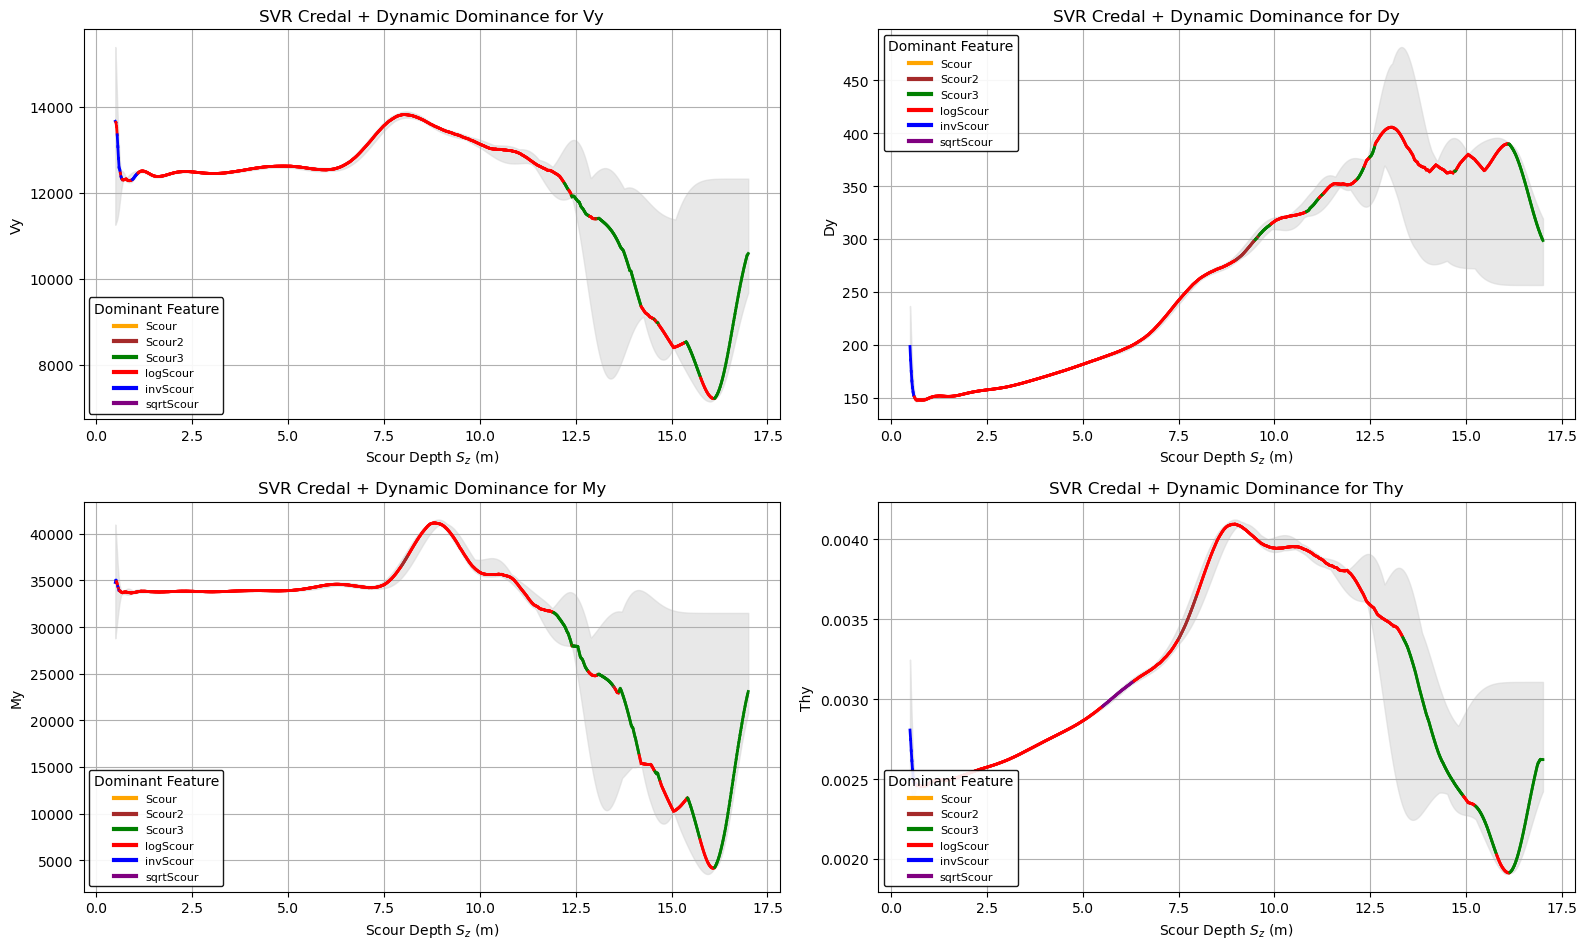

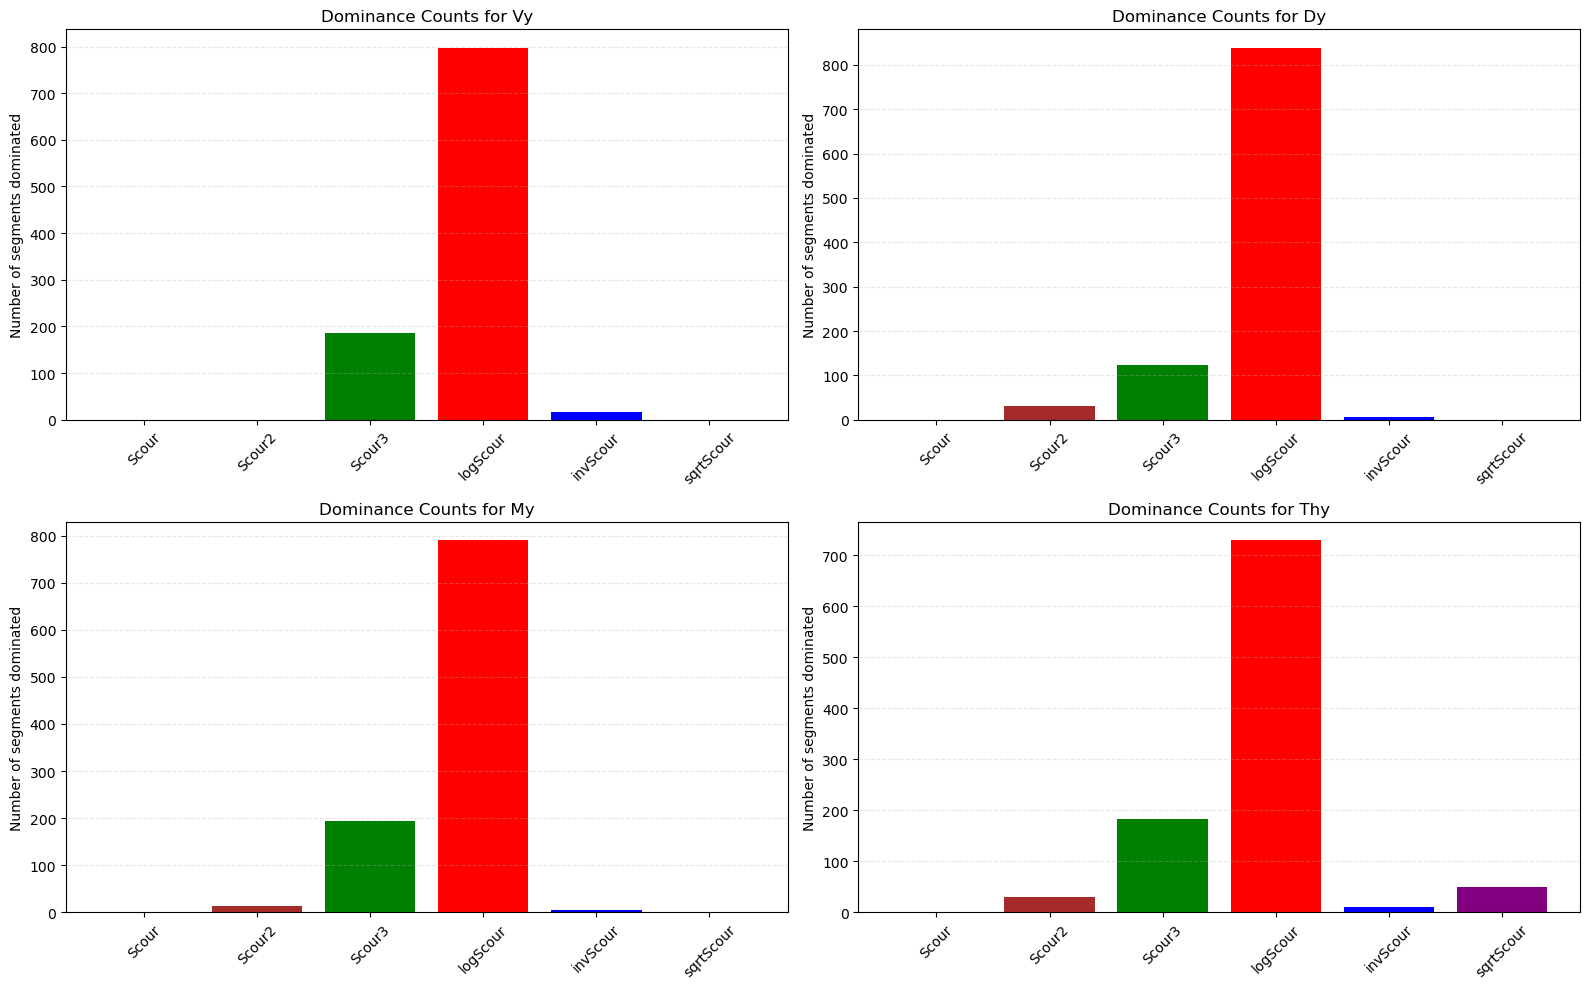

In [13]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from collections import Counter

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR_raw")
output_path_dir = model_folder / "Figures"
output_path_dir.mkdir(parents=True, exist_ok=True)

targets       = ['Vy','Dy','My','Thy']
features      = ["Scour","Scour2","Scour3","logScour","invScour","sqrtScour"]
feature_colors= {
    "invScour": 'blue',
    "Scour3":   'green',
    "Scour":    'orange',
    "sqrtScour":'purple',
    "Scour2":   'brown',
    "logScour": 'red'
}
perturb = 1.05  # +5%

# --- Precompute scour & raw features ---
sz_m = np.linspace(0.5, 17, 1000)
raw = np.column_stack([
    sz_m * 1000,
    (sz_m * 1000) ** 2,
    (sz_m * 1000) ** 3,
    np.log(sz_m * 1000),
    1 / (sz_m * 1000),
    np.sqrt(sz_m * 1000)
])

# --- 1) Plot credal bands with dynamic dominance coloring ---
dom_dict = {}
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 10))
axes1 = axes1.ravel()

for ax, target in zip(axes1, targets):
    x_s = joblib.load(model_folder / f"x_scaler_{target}.pkl")
    y_s = joblib.load(model_folder / f"y_scaler_{target}.pkl")
    models = [joblib.load(model_folder / f"credal_svr_{target}_boot{i}.pkl") for i in range(30)]

    Xs = x_s.transform(raw)
    all_preds = np.stack([
        y_s.inverse_transform(m.predict(Xs).reshape(-1, 1)).ravel()
        for m in models
    ], axis=0)
    pred_lo = all_preds.min(axis=0)
    pred_hi = all_preds.max(axis=0)
    pred_med = np.median(all_preds, axis=0)

    dom = []
    for i in range(len(sz_m)):
        b_raw = raw[i].reshape(1, -1)
        b_s = x_s.transform(b_raw)
        base = np.median([m.predict(b_s)[0] for m in models])
        base_r = y_s.inverse_transform([[base]])[0, 0]

        deltas = []
        for j in range(len(features)):
            p_raw = b_raw.copy()
            p_raw[0, j] *= perturb
            p_s = x_s.transform(p_raw)
            p_med = np.median([m.predict(p_s)[0] for m in models])
            p_r = y_s.inverse_transform([[p_med]])[0, 0]
            deltas.append(abs(p_r - base_r))
        dom.append(features[np.argmax(deltas)])

    dom_dict[target] = dom

    ax.fill_between(sz_m, pred_lo, pred_hi, color='lightgray', alpha=0.5, zorder=1)
    for i in range(len(sz_m) - 1):
        ax.plot(sz_m[i:i + 2], pred_med[i:i + 2],
                color=feature_colors[dom[i]], lw=2, zorder=2)

    ax.set_title(f"SVR Credal + Dynamic Dominance for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(target)
    ax.grid(True)

    legend_elems = [Line2D([0], [0], color=feature_colors[f], lw=3, label=f) for f in features]
    loc = 'upper left' if target == 'Dy' else 'lower left'
    ax.legend(handles=legend_elems, title="Dominant Feature", loc=loc,
              frameon=True, fancybox=True, edgecolor="black", fontsize=8, framealpha=0.9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(output_path_dir / "Figure15.pdf")
plt.savefig(output_path_dir / "SVR_Credal_DynamicDominance_Multiplot.png", dpi=300)
plt.show()

# --- 2) Plot bar charts of feature dominance ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))
axes2 = axes2.ravel()

for ax, target in zip(axes2, targets):
    counts = Counter(dom_dict[target])
    values = [counts[f] for f in features]

    ax.bar(range(len(features)), values,
           color=[feature_colors[f] for f in features])
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45)
    ax.set_title(f"Dominance Counts for {target}")
    ax.set_ylabel("Number of segments dominated")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(output_path_dir / "Figure16.pdf")
plt.savefig(output_path_dir / "SVR_Credal_FeatureDominance_Barcharts.png", dpi=300)
plt.show()


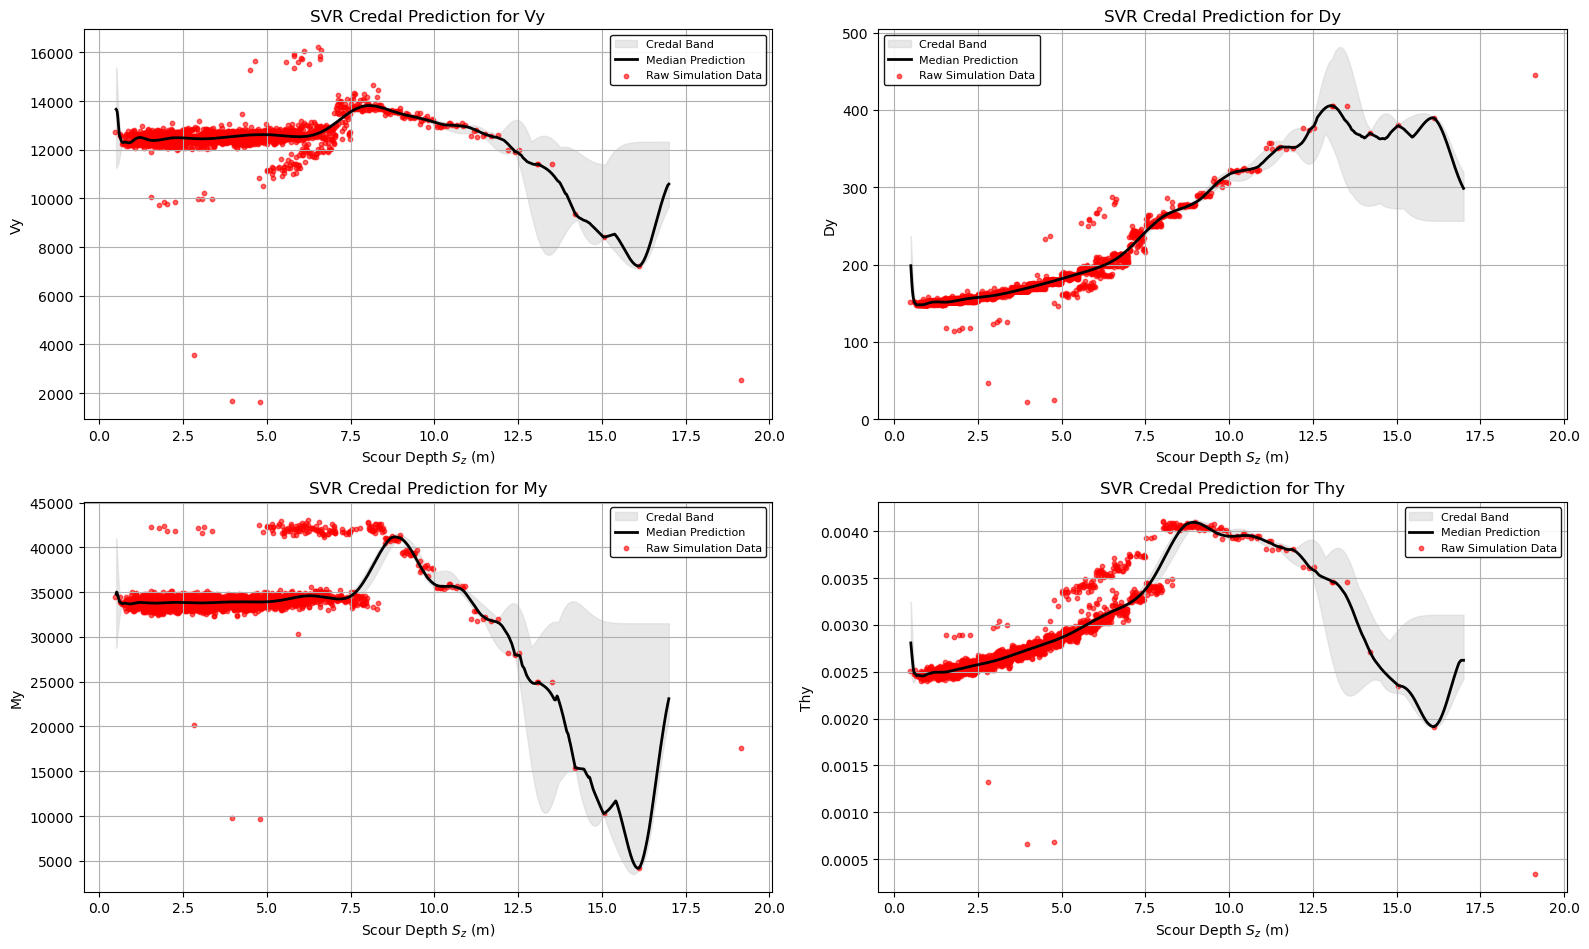

In [14]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

# --- Configuration ---
model_folder  = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR_raw")
raw_data_path = Path("RecorderData/Yield_Results_by_Scenario.xlsx")
output_path_dir = model_folder / "Figures"
output_path_dir.mkdir(parents=True, exist_ok=True)

targets       = ['Vy', 'Dy', 'My', 'Thy']
raw_cols      = ['Vy_kN', 'dy_mm', 'My_kNm', 'Thy_rad']

# --- Load raw simulation data ---
df_raw = pd.concat(pd.read_excel(raw_data_path, sheet_name=None), ignore_index=True)

# --- Precompute input features ---
sz_m = np.linspace(0.5, 17, 1000)
raw_feats = np.column_stack([
    sz_m * 1000,
    (sz_m * 1000)**2,
    (sz_m * 1000)**3,
    np.log(sz_m * 1000),
    1 / (sz_m * 1000),
    np.sqrt(sz_m * 1000)
])

# --- Plot setup ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for ax, target, raw_col in zip(axes, targets, raw_cols):
    # Load scalers and SVR models
    x_scaler = joblib.load(model_folder / f"x_scaler_{target}.pkl")
    y_scaler = joblib.load(model_folder / f"y_scaler_{target}.pkl")
    models = [
        joblib.load(model_folder / f"credal_svr_{target}_boot{i}.pkl")
        for i in range(30)
    ]

    # Scale features
    X_scaled = x_scaler.transform(raw_feats)

    # Predict ensemble
    all_preds = np.stack([
        y_scaler.inverse_transform(m.predict(X_scaled).reshape(-1, 1)).ravel()
        for m in models
    ], axis=0)
    pred_lo = all_preds.min(axis=0)
    pred_hi = all_preds.max(axis=0)
    pred_med = np.median(all_preds, axis=0)

    # --- Plot ---
    ax.fill_between(sz_m, pred_lo, pred_hi, color='lightgray', alpha=0.5, zorder=1, label="Credal Band")
    ax.plot(sz_m, pred_med, color='black', lw=2, zorder=2, label="Median Prediction")

    # Overlay raw simulation data
    ax.scatter(
        df_raw["Scour_Depth_mm"] / 1000,
        df_raw[raw_col],
        color='red', s=10, alpha=0.6, label="Raw Simulation Data"
    )

    # Decorations
    ax.set_title(f"SVR Credal Prediction for {target}")
    ax.set_xlabel("Scour Depth $S_z$ (m)")
    ax.set_ylabel(target)
    ax.grid(True)

    ax.legend(
        frameon=True, fancybox=True, edgecolor="black",
        fontsize=8, framealpha=0.9
    )

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save before showing
plt.savefig(output_path_dir / "Figure17.pdf")
plt.savefig(output_path_dir / "SVR_Credal_vs_RawData_Multiplot.png", dpi=300)
plt.show()


In [5]:
import joblib
import numpy as np
from pathlib import Path

# --- Configuration ---
model_folder = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_raw")
targets = ["Vy", "Dy"]
n_boot = 30
scour_vals = [500, 1000, 5000, 10000, 15000]

# --- Predict for Each Target ---
for target in targets:
    print(f"\n📈 Predictions for {target} across {n_boot} GBR models:")
    
    # Load 30 models for the current target
    models = [
        joblib.load(model_folder / f"credal_model_{target}_boot{i}_raw.pkl")
        for i in range(n_boot)
    ]

    # Evaluate at each scour depth
    for sz in scour_vals:
        sample = np.array([[sz, sz**2, sz**3, np.log(sz), 1/sz, np.sqrt(sz)]])
        preds = np.array([m.predict(sample)[0] for m in models])
        print(f"Scour = {sz:5d} mm → min = {preds.min():8.2f}, median = {np.median(preds):8.2f}, max = {preds.max():8.2f}")



📈 Predictions for Vy across 30 GBR models:
Scour =   500 mm → min = 12365.31, median = 12444.08, max = 12516.64
Scour =  1000 mm → min = 12328.49, median = 12420.52, max = 12508.12
Scour =  5000 mm → min = 12311.38, median = 12475.22, max = 12592.03
Scour = 10000 mm → min = 13016.54, median = 13159.33, max = 13235.98
Scour = 15000 mm → min =  7346.25, median =  8488.96, max = 11497.43

📈 Predictions for Dy across 30 GBR models:
Scour =   500 mm → min =   148.78, median =   149.85, max =   150.37
Scour =  1000 mm → min =   148.64, median =   149.44, max =   151.68
Scour =  5000 mm → min =   174.75, median =   178.46, max =   182.92
Scour = 10000 mm → min =   305.90, median =   307.51, max =   321.04
Scour = 15000 mm → min =   371.83, median =   379.42, max =   405.08


In [3]:
import joblib
import numpy as np
from pathlib import Path

# --- Configuration ---
scour_vals = [500, 1000, 5000, 10000, 15000]
targets = ["Vy", "Dy"]
features = ["Scour", "Scour2", "Scour3", "logScour", "invScour", "sqrtScour"]
model_dir = Path("RecorderData/results/Tuple_Data_Process/ML_Surrogate_Credal_SVR_raw")
n_boot = 30

# --- Predict for Each Target (Vy, Dy) ---
for target in targets:
    # Load scalers
    x_scaler = joblib.load(model_dir / f"x_scaler_{target}.pkl")
    y_scaler = joblib.load(model_dir / f"y_scaler_{target}.pkl")
    
    # Load all 30 SVR models
    models = [
        joblib.load(model_dir / f"credal_svr_{target}_boot{i}.pkl")
        for i in range(n_boot)
    ]

    print(f"\n📈 Predictions for {target} across 30 SVR models:")
    for sz in scour_vals:
        raw_feat = np.array([[sz, sz**2, sz**3, np.log(sz), 1/sz, np.sqrt(sz)]])
        X_scaled = x_scaler.transform(raw_feat)
        
        preds_scaled = np.array([model.predict(X_scaled)[0] for model in models])
        preds = y_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()

        print(f"Scour = {sz} mm → min = {preds.min():.2f}, median = {np.median(preds):.2f}, max = {preds.max():.2f}")



📈 Predictions for Vy across 30 SVR models:
Scour = 500 mm → min = 11257.10, median = 13662.76, max = 15388.41
Scour = 1000 mm → min = 12332.42, median = 12366.90, max = 12497.20
Scour = 5000 mm → min = 12582.51, median = 12618.92, max = 12639.30
Scour = 10000 mm → min = 13050.03, median = 13133.21, max = 13234.92
Scour = 15000 mm → min = 8313.01, median = 8476.01, max = 11400.96

📈 Predictions for Dy across 30 SVR models:
Scour = 500 mm → min = 164.76, median = 198.47, max = 236.69
Scour = 1000 mm → min = 148.59, median = 149.69, max = 150.88
Scour = 5000 mm → min = 181.25, median = 181.51, max = 181.87
Scour = 10000 mm → min = 309.34, median = 316.61, max = 320.50
Scour = 15000 mm → min = 272.62, median = 378.04, max = 383.41
